# IMPORTS & FUNCTIONS

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import itertools, pickle
import seaborn as sns
sns.color_palette()
sns.set_theme()


In [2]:
# GLOBAL VARS
FREQ_X86 = 2600000000
FREQ_RISCV = 1200000000

# FUNCTIONS
# Get job info into a dict
def get_job_info(job):
    job_dict = dict()
    stripe = job.split(",")
    for line in stripe:
        cleanline = line.replace('"',"").replace("{","").replace("}","")
        splitline = cleanline.split(":")
        job_dict[splitline[0]] = splitline[1:]

    return job_dict

# Print START JOB basic info
def print_job_start_info(job):
    print("Event: ", str(job_info['Event']))
    if 'Job ID' in job_info:
        print("Job ID: ", job_info['Job ID'])
    if 'Stage Name' in job_info:
        print("Stage Name: ",job_info['Stage Name'])
    if 'Submission Time' in job_info:
        print("Completion time: ", job_info['Submission Time'])
    if 'spark.app.submitTime' in job_info:
        print("Spark SubmitTime: ", job_info['spark.app.submitTime'])

# Print END JOB basic info
def print_job_end_info(job):
    print("Event: ", str(job_info['Event']))
    if 'Job ID' in job_info:
        print("Job ID: ", job_info['Job ID'])
    if 'Completion Time' in job_info:
        print("Completion time: ", job_info['Completion Time'])
    if 'Result' in job_info:
        print("Job Result: ", job_info['Result'])

# Get main job info
def get_main_job_info(lines):
    n = 0
    events = dict()
    print_info = False
    for line in lines:
        n+=1
        sline = line.split(",")        
        event = sline[0].replace('{"Event":"',"").replace('"',"")
        #print(f'Event is {event}')
        job_info = get_job_info(line)
        if job_info['Event'] == ['SparkListenerJobStart']:
            if print_info:
                print_job_start_info(job_info)
                print("")
    
        if job_info['Event'] == ['SparkListenerJobEnd']:
            if print_info:
                print_job_end_info(job_info)
                print("")
        
        if event not in events:
            events[event] = list()
        events[event].append(line)
        
    return events

# Get job times by job ID
def get_times_by_job_ID(events):
    event_times_by_ID = dict()
    for start_job in events['SparkListenerJobStart']:
        j_info = get_job_info(start_job)
        event_times_by_ID[j_info['Job ID'][0]] = {'Job ID': j_info['Job ID'], 'Stage Name': j_info['Stage Name'][0], 'Submission Time': j_info['Submission Time'][0]}
    
    # Get completing time info
    for end_job in events['SparkListenerJobEnd']:
        j_info = get_job_info(end_job)
        job_summary = event_times_by_ID[j_info['Job ID'][0]]
        job_summary['Completion Time'] = j_info['Completion Time'][0]
        job_summary['Running time'] = int(j_info['Completion Time'][0]) - int(job_summary['Submission Time'])
        event_times_by_ID[j_info['Job ID'][0]] = job_summary

    return event_times_by_ID

# Get job times by job name
def get_times_by_names(event_times_by_ID):
    event_times_by_names = dict()
    for key, val in event_times_by_ID.items():
        job_info = {'Job ID': key, 'Submission Time': val['Submission Time'], 'Completion Time' : val['Completion Time'], 'Running time' : val['Running time']}
        if val['Stage Name'] not in event_times_by_names:
            event_times_by_names[val['Stage Name']] = list()
        event_times_by_names[val['Stage Name']].append(job_info)
    return event_times_by_names

# Get job run time by job name
def get_run_times_by_names_and_ID(event_times_by_ID):
    run_time_by_name = dict()
    run_time_by_ID = dict()
    for key, val in event_times_by_ID.items():
        if val['Stage Name'] not in run_time_by_name:
            run_time_by_name[val['Stage Name']] = list()
        run_time_by_name[val['Stage Name']].append(val['Running time'])
        run_time_by_ID[key] = val['Running time']
    return run_time_by_name, run_time_by_ID

# Get next and previous delay run time by job name
def get_delay_times_by_name_and_ID(event_times_by_ID):
    delay_times_by_ID = dict()
    delay_times_by_name = dict()
    keys = list(event_times_by_ID.keys())
    for n in range(len(keys)):
        this_job = event_times_by_ID[keys[n]]
        this_job_init = this_job['Submission Time']
        this_job_end = this_job['Completion Time']

        if n < len(keys)-1:
            next_job = event_times_by_ID[keys[n+1]]
            next_job_init = next_job['Submission Time']
        else:
            next_job_init = this_job_end

        if n > 0:
            past_job = event_times_by_ID[keys[n-1]]
            past_job_end = past_job['Completion Time']
        else:
            past_job_end = this_job_init
        
        delay_info = {'Previous Delay': int(this_job_init) - int(past_job_end), 'Next Delay': int(next_job_init) - int(this_job_end)}

        if this_job['Stage Name'] not in delay_times_by_name:
            delay_times_by_name[this_job['Stage Name']] = list()
        delay_times_by_name[this_job['Stage Name']].append(delay_info)

        delay_times_by_ID[keys[n]] = delay_info

    return delay_times_by_name, delay_times_by_ID

# Get previous and next times for boxplot
def get_prev_next_data(delay_times_by_name, f):
    keys = list(delay_times_by_name.keys())
    data_prev = list()
    data_next = list()
    for k, v in delay_times_by_name.items():
        aux_prev = list()
        aux_next = list()
        for delay in v:
            aux_prev.append(int(delay['Previous Delay'])*f/1000)
            aux_next.append(int(delay['Next Delay'])*f/1000)
        data_prev.append(aux_prev)
        data_next.append(aux_next)
    return data_prev, data_next

# Get ratio of delays in both architectures
def get_ratio_delays(data_x86_next, data_riscv_next):
    ratio = list()
    for n in range(len(data_x86_next)):
        aux = list()
        for m in range(len(data_x86_next[n])):
            if data_x86_next[n][m] == 0:
                aux.append(0)
            else:
                aux.append(data_riscv_next[n][m]/data_x86_next[n][m])
        ratio.append(aux)
        
    return ratio

# Get ratio of runtimes in both architectures
def get_ratio_runtimes(data_x86_next, data_riscv_next):
    ratio = list()
    for n in range(len(data_x86_next)):
        aux = list()
        for m in range(len(data_x86_next[n])):
            if data_x86_next[n][m] == 0:
                aux.append(0)
            else:
                aux.append(data_riscv_next[n][m]/data_x86_next[n][m])
        ratio.append(aux)
        
    return ratio


# Convert runtime to cycles
def runtime_to_cycles(data, f):
    cycles = list()
    for n in data:
        aux = list()
        for m in n:
            aux.append(m*f/1000)
        cycles.append(aux)
        
    return cycles

# Add median to axes
def add_median_to_ax(bp, ax1, num_boxes, ypos = .85, xpos=.0, c = "black"):

    # Get medians
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        med = bp['medians'][i]
        median_y = []
        for j in range(2):
            median_y.append(med.get_ydata()[j])
        medians[i] = median_y[0]
    upper_labels = ['m = ' + str(round(s, 2)) for s in medians]

    # Plot in axes
    pos = np.arange(num_boxes) + 1
    weights = ['bold', 'semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick]+xpos, ypos, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='small',
                 weight=weights[k], color = c)


In [3]:
# PATHS
datapath = "data/"

# MULTINODE ANALYSIS

## EXTRACT X86 INFORMATION

In [4]:
# LOAD X86 DATA
with open(datapath + 'run_x86/x86_app_I1_W3_C4_F5') as f_x86:
    lines_x86 = f_x86.readlines()

In [5]:
# MAIN
# Extract main information from jobs 
events_x86 = get_main_job_info(lines_x86)

# Get event info dict where key is the job ID and value a dict with times information and job name
event_times_by_ID_x86 = get_times_by_job_ID(events_x86)

# Get event info dict where key is the job name and value a dict with times information
event_times_by_name_x86 = get_times_by_names(event_times_by_ID_x86)

# Get run time dict where key is the job name and value the running time
run_times_by_name_x86, run_times_by_ID_x86 = get_run_times_by_names_and_ID(event_times_by_ID_x86)

# Get delay time dict where key is the job name and value a dict with previos and next delay time
delay_times_by_name_x86, delay_times_by_ID_x86 = get_delay_times_by_name_and_ID(event_times_by_ID_x86)


## EXTRACT RISCV INFORMATION

In [6]:
# LOAD RISCV DATA
with open(datapath + 'run_riscv/riscv_app_I1_W3_C4_F5') as f_riscv:
    lines_riscv = f_riscv.readlines()

In [7]:
# MAIN
# Extract main information from jobs 
events_riscv = get_main_job_info(lines_riscv)

# Get event info dict where key is the job ID and value a dict with times information and job name
event_times_by_ID_riscv = get_times_by_job_ID(events_riscv)

# Get event info dict where key is the job name and value a dict with times information
event_times_by_name_riscv = get_times_by_names(event_times_by_ID_riscv)

# Get run time dict where key is the job name and value the running time
run_times_by_name_riscv, run_times_by_ID_riscv = get_run_times_by_names_and_ID(event_times_by_ID_riscv)

# Get delay time dict where key is the job name and value a dict with previos and next delay time
delay_times_by_name_riscv, delay_times_by_ID_riscv = get_delay_times_by_name_and_ID(event_times_by_ID_riscv)


## DATA PLOTS

### RUNNING TIMES BOX PLOT

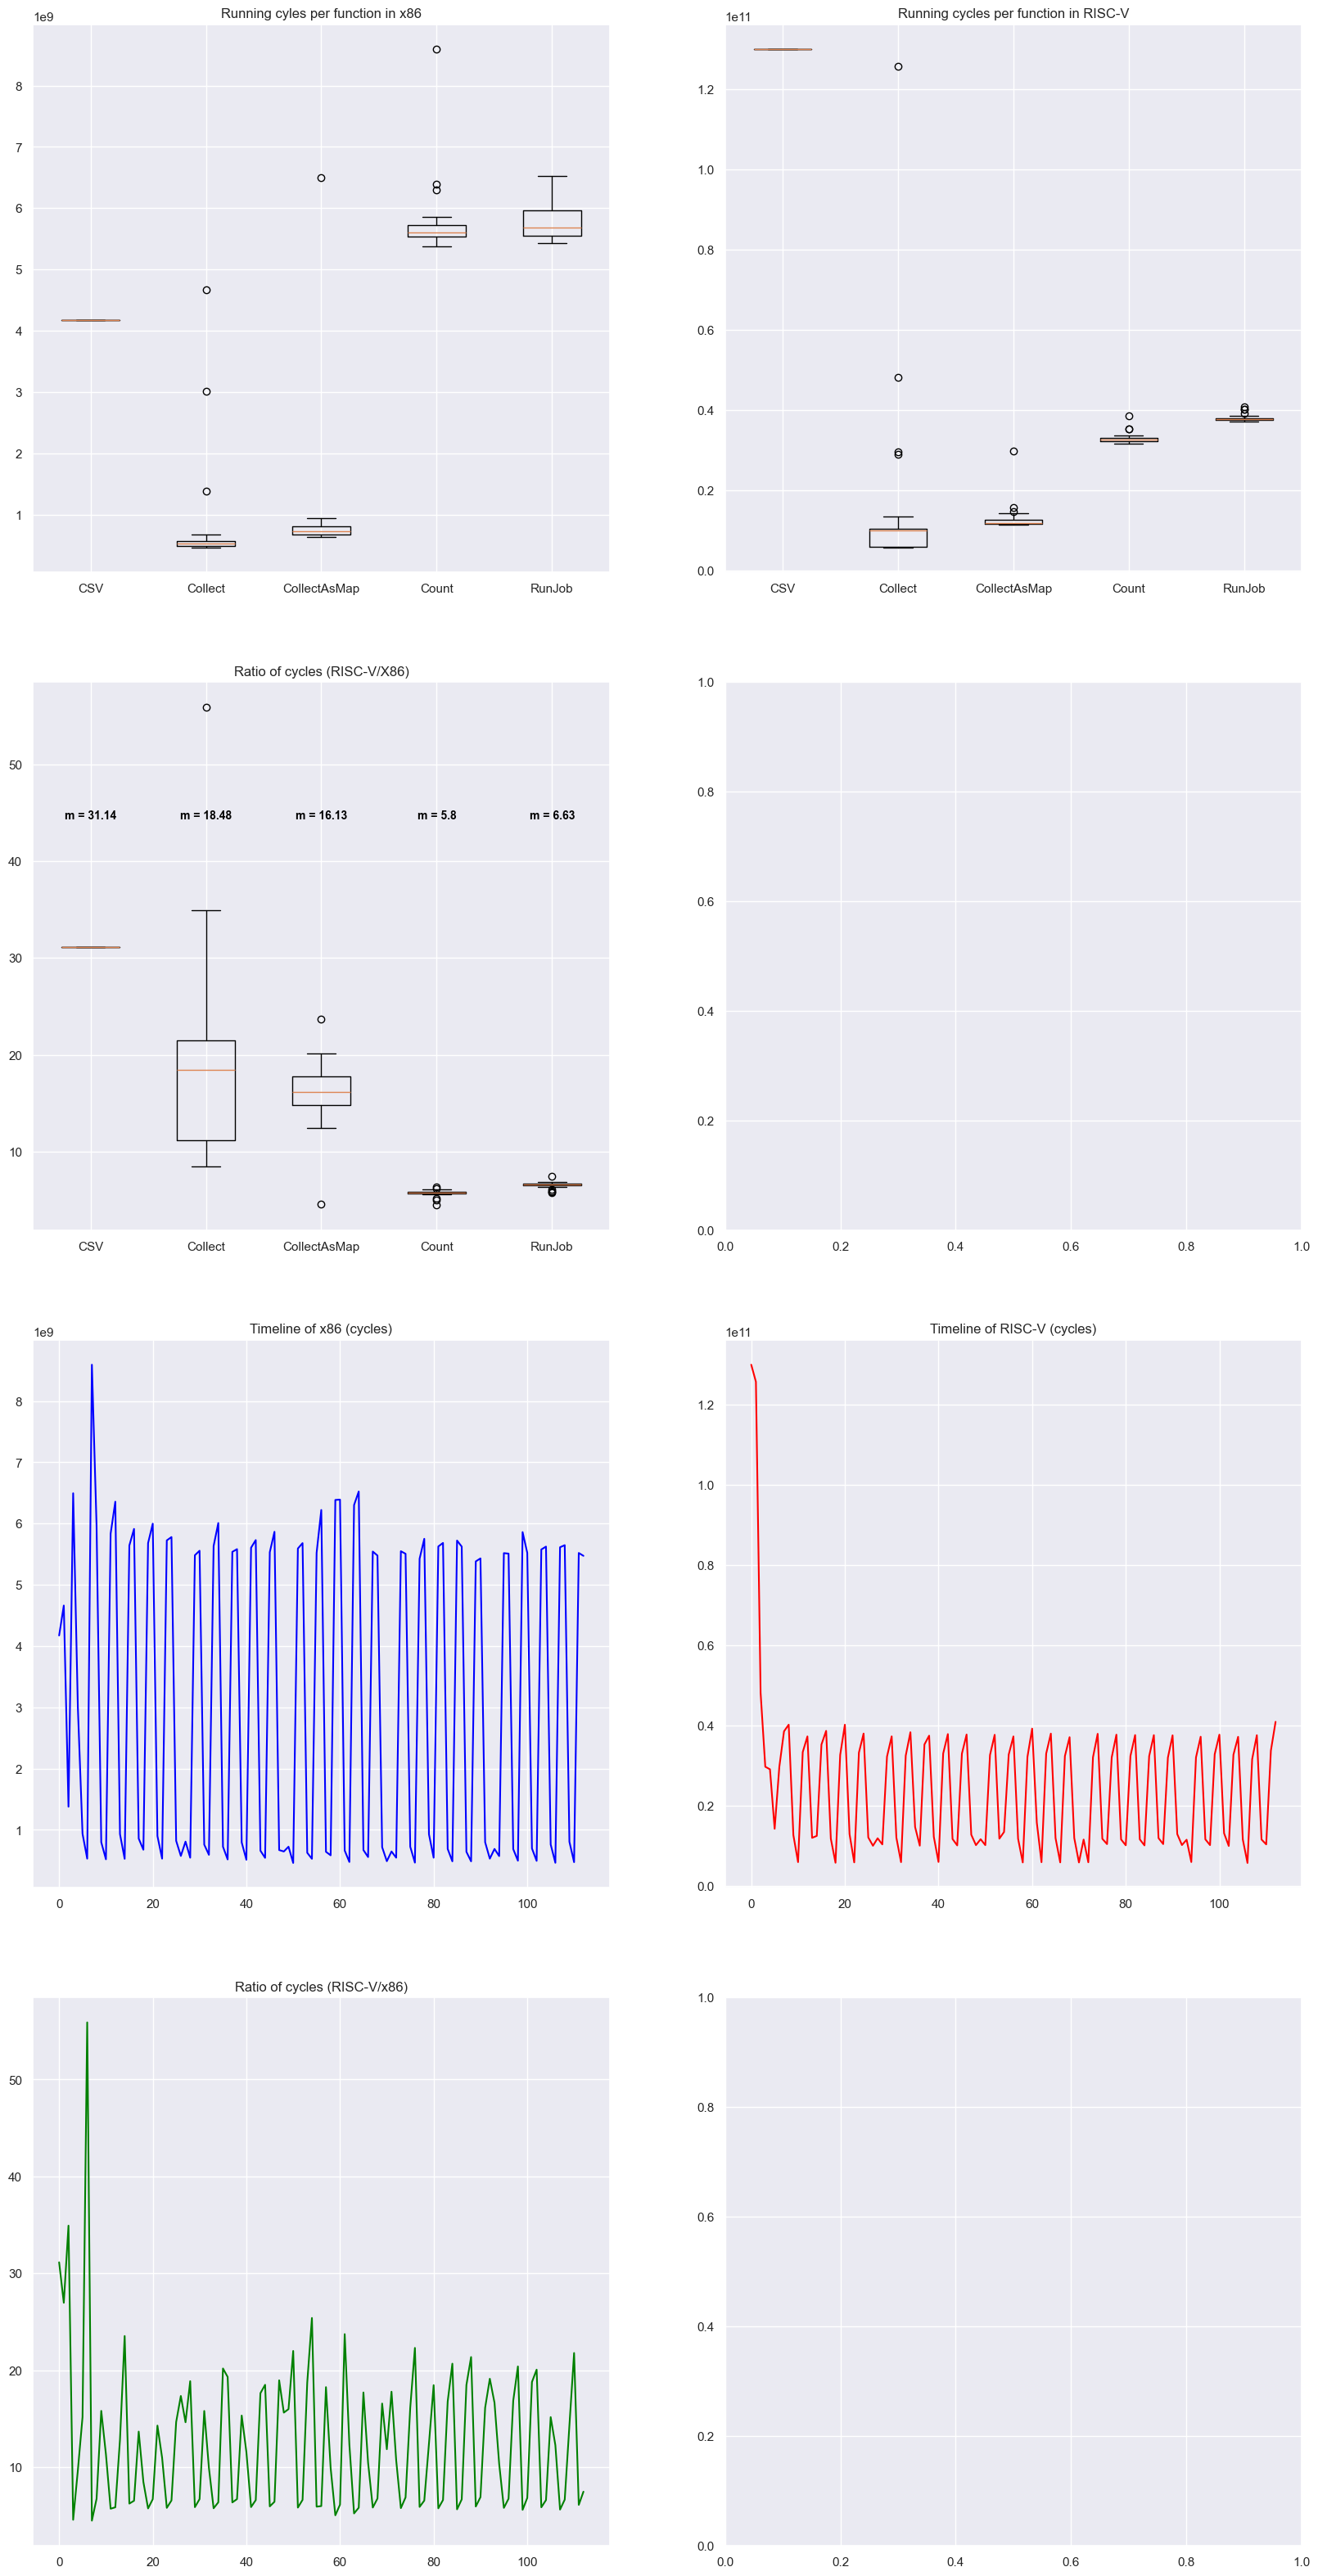

In [8]:
# BOX PLOT
keys_x86 = list(run_times_by_name_x86.keys())
data_x86 = [run_times_by_name_x86[keys_x86[x]] for x in range(len(keys_x86))]
cycles_x86 = runtime_to_cycles(data_x86, FREQ_X86)

keys_riscv = list(run_times_by_name_riscv.keys())
data_riscV = [run_times_by_name_riscv[keys_riscv[x]] for x in range(len(keys_riscv))]
cycles_riscv = runtime_to_cycles(data_riscV, FREQ_RISCV)

ratio_runtimes = get_ratio_runtimes(cycles_x86, cycles_riscv)

# Timeline
timeline_x86 = np.array([x*FREQ_X86/1000 for x in list(run_times_by_ID_x86.values())])
timeline_riscv = np.array([x*FREQ_RISCV/1000 for x in list(run_times_by_ID_riscv .values())])

ratio_timeline = timeline_riscv/timeline_x86

labels = ['CSV', 'Collect', 'CollectAsMap', 'Count', 'RunJob']
num_boxes = len(labels)

fig, ax = plt.subplots(4,2)
fig.set_figwidth(20)
fig.set_figheight(40)

# Box plots
ax[0][0].set_title('Running cyles per function in x86')
bp = ax[0][0].boxplot(cycles_x86, labels=labels)
#add_median_to_ax(bp, ax[0][0], num_boxes)

ax[0][1].set_title('Running cycles per function in RISC-V')
bp = ax[0][1].boxplot(cycles_riscv, labels=labels)
#add_median_to_ax(bp, ax[0][1], num_boxes)

# Ratio
ax[1][0].set_title('Ratio of cycles (RISC-V/X86)')
bp = ax[1][0].boxplot(ratio_runtimes, labels=labels)
add_median_to_ax(bp, ax[1][0], num_boxes, .75)

# Time line
ax[2][0].set_title('Timeline of x86 (cycles)')
ax[2][0].plot(timeline_x86, color = 'blue')
ax[2][1].set_title('Timeline of RISC-V (cycles)')
ax[2][1].plot(timeline_riscv, color = 'red')

# Ratio
ax[3][0].set_title('Ratio of cycles (RISC-V/x86)')
ax[3][0].plot(ratio_timeline, color = 'green')

plt.show()



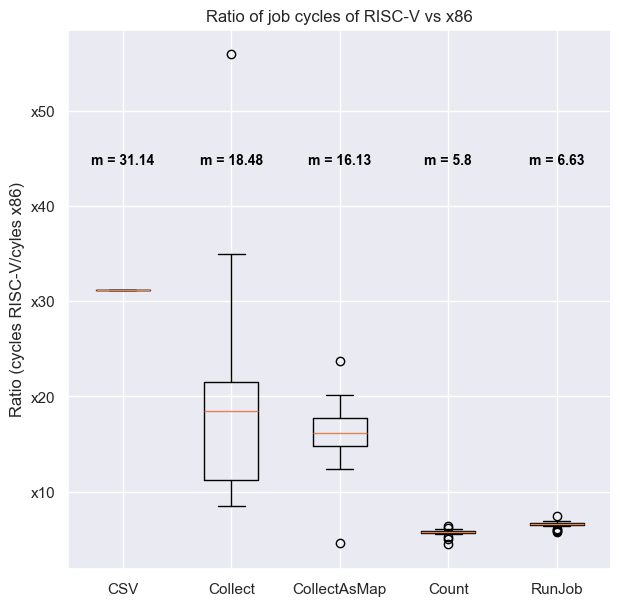

In [29]:
# Save plot
fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)

# Ratio
ax.set_title('Ratio of job cycles of RISC-V vs x86')
ax.set_ylabel('Ratio (cycles RISC-V/cyles x86)')
bp = ax.boxplot(ratio_runtimes, labels=labels)
add_median_to_ax(bp, ax, num_boxes, .75)
ax.set_yticks((10,20,30,40,50))
ax.set_yticklabels(("x10","x20","x30","x40","x50"))

plt.savefig('figures/runtimes_ratio.png', bbox_inches='tight')


### RUNNING TIMES DISTRIBUTION STACKED CHART PLOT

Cumulative times until job CSV: [0.01205742 0.04708273]
Cumulative times until job Collect: [0.08260651 0.21744514]
Cumulative times until job CollectAsMap: [0.16430401 0.35690383]
Cumulative times until job Count: [0.58155853 0.65572226]
Cumulative times until job RunJob: [1. 1.]


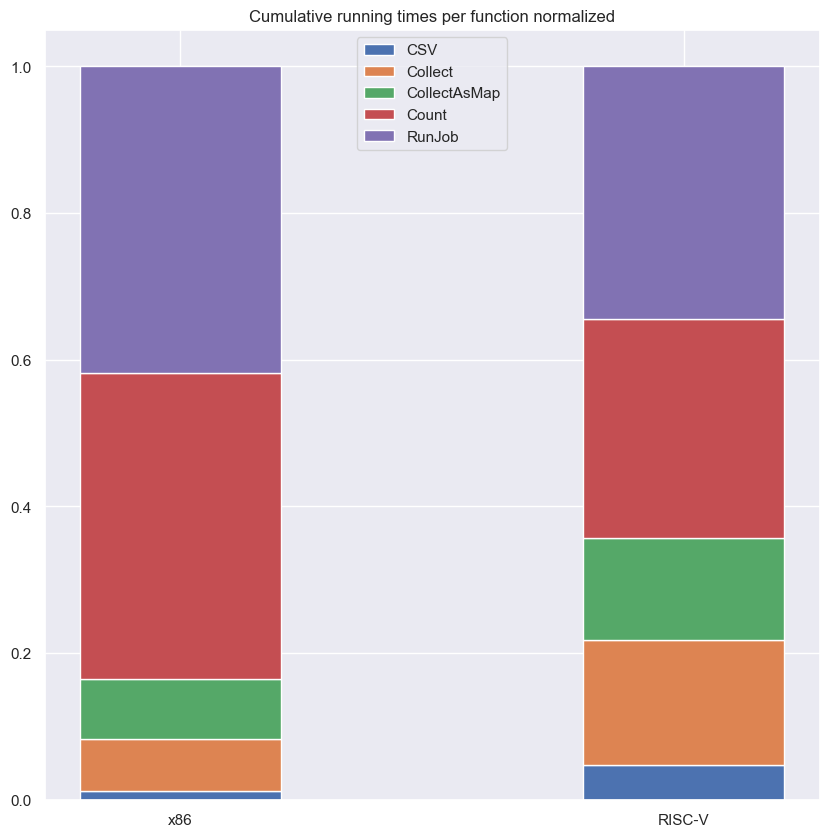

In [25]:
# STACKED CHART PLOT
keys_x86 = list(run_times_by_name_x86.keys())
keys_riscv = list(run_times_by_name_riscv.keys())

architectures = (
    "x86",
    "RISC-V",
)

run_time_x86 = 0
for k,v in run_times_by_name_x86.items():
    run_time_x86+= sum(v)
    
run_time_riscv = 0
for k,v in run_times_by_name_riscv.items():
    run_time_riscv+= sum(v)
    
runtimes_cum_percentage = {
    "CSV": np.array([sum(run_times_by_name_x86[keys_x86[0]])/run_time_x86, sum(run_times_by_name_riscv[keys_riscv[0]])/run_time_riscv]),
    "Collect": np.array([sum(run_times_by_name_x86[keys_x86[1]])/run_time_x86, sum(run_times_by_name_riscv[keys_riscv[1]])/run_time_riscv]),
    "CollectAsMap": np.array([sum(run_times_by_name_x86[keys_x86[2]])/run_time_x86, sum(run_times_by_name_riscv[keys_riscv[2]])/run_time_riscv]),
    "Count": np.array([sum(run_times_by_name_x86[keys_x86[3]])/run_time_x86, sum(run_times_by_name_riscv[keys_riscv[3]])/run_time_riscv]),
    "RunJob": np.array([sum(run_times_by_name_x86[keys_x86[4]])/run_time_x86, sum(run_times_by_name_riscv[keys_riscv[4]])/run_time_riscv])
}

width = 0.4

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)

bottom = np.zeros(2)

for job_name, runtime_cum in runtimes_cum_percentage.items():
    p = ax.bar(architectures, runtime_cum, width, label=job_name, bottom=bottom)
    bottom += runtime_cum
    print("Cumulative times until job " + job_name + ": " + str(bottom))

ax.set_title("Cumulative running times per function normalized")
ax.legend(loc="upper center")

plt.savefig('runtimes.png')

plt.show()


### DELAY TIMES BOX PLOT

Average delay ratio is 70.13309798092538


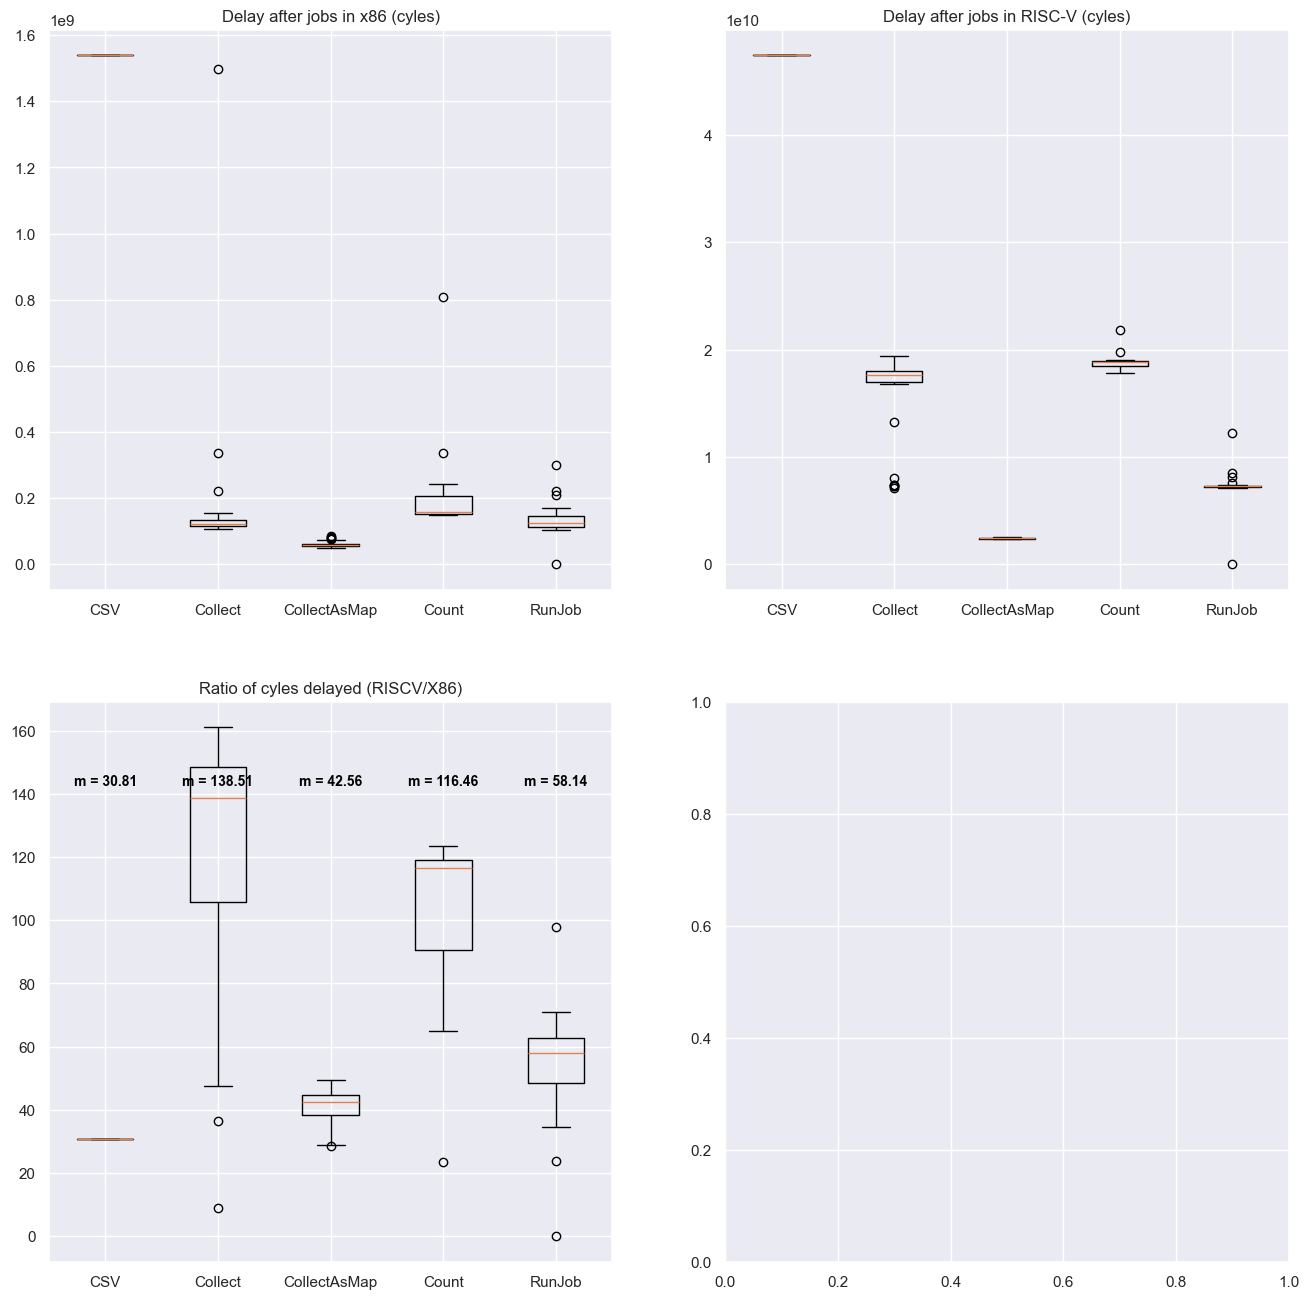

In [26]:
# BOX PLOT
# Get lists per function
data_x86_prev, data_x86_next = get_prev_next_data(delay_times_by_name_x86, FREQ_X86)
data_riscv_prev, data_riscv_next = get_prev_next_data(delay_times_by_name_riscv, FREQ_RISCV)
ratio_next = get_ratio_delays(data_x86_next, data_riscv_next)

avg_ratio = [sum(x)/len(x) for x in ratio_next]
print("Average delay ratio is " + str(sum(avg_ratio)/len(avg_ratio)))

labels = ['CSV', 'Collect', 'CollectAsMap', 'Count', 'RunJob']

fig, ax = plt.subplots(2,2)
fig.set_figwidth(16)
fig.set_figheight(16)

# Next delay
ax[0][0].set_title('Delay after jobs in x86 (cyles)')
bp = ax[0][0].boxplot(data_x86_next, labels=labels)

ax[0][1].set_title('Delay after jobs in RISC-V (cyles)')
bp = ax[0][1].boxplot(data_riscv_next, labels=labels)

# Ratio
ax[1][0].set_title('Ratio of cyles delayed (RISCV/X86)')
bp = ax[1][0].boxplot(ratio_next, labels=labels)
add_median_to_ax(bp, ax[1][0], num_boxes, 0.85)

plt.show()

Average delay ratio is 70.13309798092538


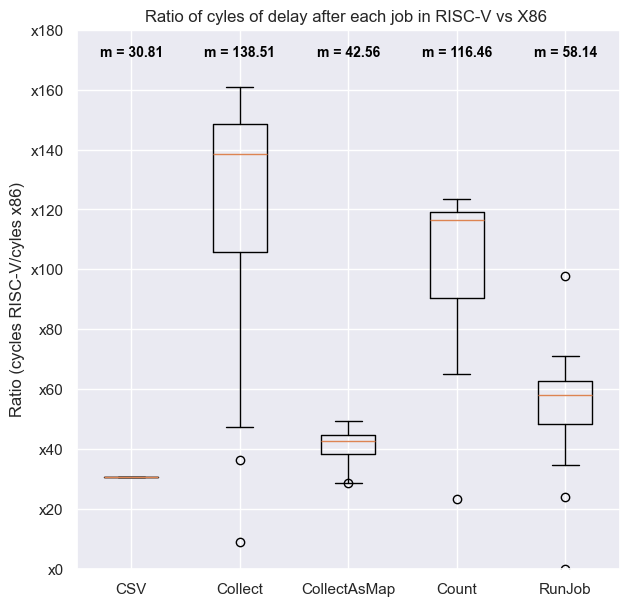

In [32]:
# BOX PLOT
# Get lists per function
data_x86_prev, data_x86_next = get_prev_next_data(delay_times_by_name_x86, FREQ_X86)
data_riscv_prev, data_riscv_next = get_prev_next_data(delay_times_by_name_riscv, FREQ_RISCV)
ratio_next = get_ratio_delays(data_x86_next, data_riscv_next)

avg_ratio = [sum(x)/len(x) for x in ratio_next]
print("Average delay ratio is " + str(sum(avg_ratio)/len(avg_ratio)))

labels = ['CSV', 'Collect', 'CollectAsMap', 'Count', 'RunJob']

fig, ax = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)

# Ratio
ax.set_title('Ratio of cyles of delay after each job in RISC-V vs X86 ')
ax.set_ylim(0,180)
ax.set_ylabel('Ratio (cycles RISC-V/cyles x86)')
bp = ax.boxplot(ratio_next, labels=labels)
add_median_to_ax(bp, ax, num_boxes, 0.95)
ax.set_yticks((0,20,40,60,80,100,120,140,160,180))
ax.set_yticklabels(("x0","x20","x40","x60","x80","x100","x120","x140","x160","x180"))


plt.savefig('figures/delay_ratio.png', bbox_inches='tight')

plt.show()

Cumulative times until job CSV: [0.08749631 0.03718484]
Cumulative times until job Collect: [0.40851315 0.43156854]
Cumulative times until job CollectAsMap: [0.51256281 0.489193  ]
Cumulative times until job Count: [0.80712385 0.85809327]
Cumulative times until job RunJob: [1. 1.]


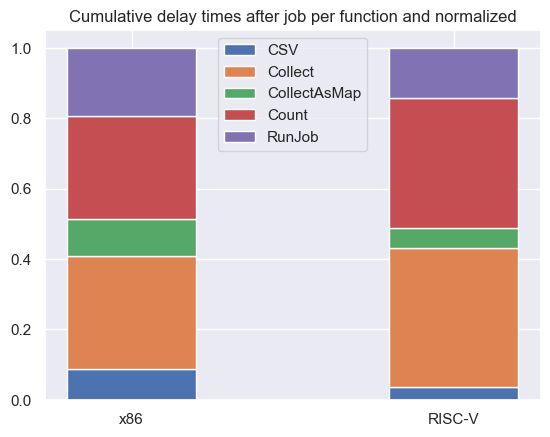

In [28]:
# STACKED CHART PLOT
keys_x86 = list(run_times_by_name_x86.keys())
keys_riscv = list(run_times_by_name_riscv.keys())

data_x86_prev, data_x86_next = get_prev_next_data(delay_times_by_name_x86, FREQ_X86)
data_riscv_prev, data_riscv_next = get_prev_next_data(delay_times_by_name_riscv, FREQ_RISCV)

architectures = (
    "x86",
    "RISC-V",
)

delay_time_x86 = 0
for v in data_x86_next:
    delay_time_x86+= sum(v)
    
delay_time_riscv = 0
for v in data_riscv_next:
    delay_time_riscv+= sum(v)
    
runtimes_cum_percentage = {
    "CSV": np.array([sum(data_x86_next[0])/delay_time_x86, sum(data_riscv_next[0])/delay_time_riscv]),
    "Collect": np.array([sum(data_x86_next[1])/delay_time_x86, sum(data_riscv_next[1])/delay_time_riscv]),
    "CollectAsMap": np.array([sum(data_x86_next[2])/delay_time_x86, sum(data_riscv_next[2])/delay_time_riscv]),
    "Count": np.array([sum(data_x86_next[3])/delay_time_x86, sum(data_riscv_next[3])/delay_time_riscv]),
    "RunJob": np.array([sum(data_x86_next[4])/delay_time_x86, sum(data_riscv_next[4])/delay_time_riscv])
}

width = 0.4

fig, ax = plt.subplots()
bottom = np.zeros(2)

for job_name, runtime_cum in runtimes_cum_percentage.items():
    p = ax.bar(architectures, runtime_cum, width, label=job_name, bottom=bottom)
    bottom += runtime_cum
    print("Cumulative times until job " + job_name + ": " + str(bottom))


ax.set_title("Cumulative delay times after job per function and normalized")
ax.legend(loc="upper center")

plt.show()


### TOTAL DELAYS

In [29]:
# Delays
total_cycles_delays_x86 = sum([sum(x) for x in data_x86_next])
total_cycles_delays_riscv = sum([sum(x) for x in data_riscv_next])
cycles_delays_ratio = (total_cycles_delays_riscv)/(total_cycles_delays_x86)

print("Delays x86 (10^9): " + str((total_cycles_delays_x86)/1000000000))
print("Delays RISC-V (10^9): " + str((total_cycles_delays_riscv)/1000000000))
print("Cycles faster of delays in x86 than RISC-V: " + str(cycles_delays_ratio))
print("")

# Load Jobs
total_cycles_jobs_load_x86 = sum([sum(x) for x in cycles_x86[0:3]])
total_cycles_jobs_load_riscv = sum([sum(x) for x in cycles_riscv[0:3]])
cycles_jobs_load_ratio = (total_cycles_jobs_load_riscv)/(total_cycles_jobs_load_x86)

print("Load cycles of jobs in x86 (10^9): " + str((total_cycles_jobs_load_x86)/1000000000))
print("Load cycles of jobs in RISC-V (10^9): " + str((total_cycles_jobs_load_riscv)/1000000000))
print("Cycles faster of load jobs in x86 than RISC-V: " + str(cycles_jobs_load_ratio))
print("")

# Run Jobs
total_cycles_jobs_run_x86 = sum([sum(x) for x in cycles_x86[3:]])
total_cycles_jobs_run_riscv = sum([sum(x) for x in cycles_riscv[3:]])
cycles_jobs_run_ratio = (total_cycles_jobs_run_riscv)/(total_cycles_jobs_run_x86)

print("Run cycles of jobs in x86 (10^9): " + str((total_cycles_jobs_run_x86)/1000000000))
print("Run cycles of jobs in RISC-V (10^9): " + str((total_cycles_jobs_run_riscv)/1000000000))
print("Cycles faster of running jobs in x86 than RISC-V: " + str(cycles_jobs_run_ratio))
print("")

# Total Jobs
total_cycles_jobs_x86 = sum([sum(x) for x in cycles_x86])
total_cycles_jobs_riscv = sum([sum(x) for x in cycles_riscv])
cycles_jobs_ratio = (total_cycles_jobs_riscv)/(total_cycles_jobs_x86)

print("Total run cycles of jobs in x86 (10^9): " + str((total_cycles_jobs_x86)/1000000000))
print("Total run cycles of jobs in RISC-V (10^9): " + str((total_cycles_jobs_riscv)/1000000000))
print("Cycles faster of jobs in x86 than RISC-V: " + str(cycles_jobs_ratio))
print("")
      
# Total time
cycles_total_x86 = (2*60+25)*FREQ_X86
cycles_total_riscv = 60*60*FREQ_RISCV
cycles_total_ratio = cycles_total_riscv/cycles_total_x86

print("Total run x86 (10^9): " + str((cycles_total_x86)/1000000000))
print("Total run RISC-V (10^9): " + str((cycles_total_riscv)/1000000000))
print("Cycles faster in total x86 than RISC-V: " + str(cycles_total_ratio))
print("")

init_cycles_x86 = cycles_total_x86 - (total_cycles_delays_x86 + total_cycles_jobs_load_x86 + total_cycles_jobs_run_x86)
init_cycles_riscv = cycles_total_riscv - (total_cycles_delays_riscv + total_cycles_jobs_load_riscv + total_cycles_jobs_run_riscv)
cycles_init_ratio = init_cycles_riscv/init_cycles_x86


print("Init cycles x86 (10^9): " + str((init_cycles_x86)/1000000000))
print("Init cycles RISC-V (10^9): " + str((init_cycles_riscv)/1000000000))
print("Cycles faster init x86 than RISC-V: " + str(cycles_init_ratio))



Delays x86 (10^9): 17.5916
Delays RISC-V (10^9): 1275.2292
Cycles faster of delays in x86 than RISC-V: 72.49080242843175

Load cycles of jobs in x86 (10^9): 56.8646
Load cycles of jobs in RISC-V (10^9): 985.0884
Cycles faster of load jobs in x86 than RISC-V: 17.32340331242988

Run cycles of jobs in x86 (10^9): 289.2292
Run cycles of jobs in RISC-V (10^9): 1775.0064
Cycles faster of running jobs in x86 than RISC-V: 6.13702350938287

Total run cycles of jobs in x86 (10^9): 346.0938
Total run cycles of jobs in RISC-V (10^9): 2760.0948
Cycles faster of jobs in x86 than RISC-V: 7.9749905950352185

Total run x86 (10^9): 377.0
Total run RISC-V (10^9): 4320.0
Cycles faster in total x86 than RISC-V: 11.458885941644562

Init cycles x86 (10^9): 13.3146
Init cycles RISC-V (10^9): 284.676
Cycles faster init x86 than RISC-V: 21.38073993961516


0.013
0.285
0.018
1.275
0.057
0.985
0.289
1.775
0.377
4.32


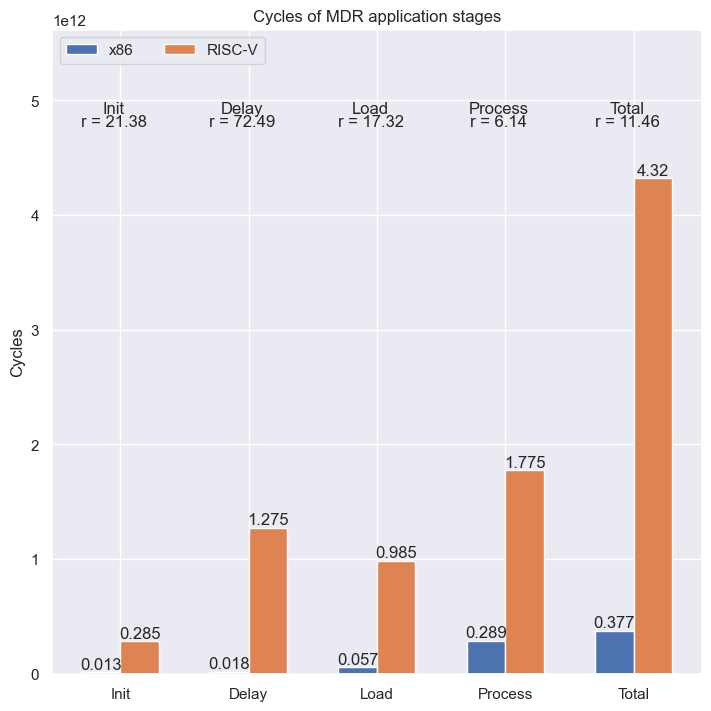

In [30]:
# Create list of values

sns.color_palette()
sns.set_theme()

arch = ("Init", "Delay", "Load", "Process", "Total")
cycles = {
    'x86': (init_cycles_x86, total_cycles_delays_x86, total_cycles_jobs_load_x86, total_cycles_jobs_run_x86, cycles_total_x86),
    'RISC-V': (init_cycles_riscv, total_cycles_delays_riscv, total_cycles_jobs_load_riscv, total_cycles_jobs_run_riscv, cycles_total_riscv)
}
ratios = [cycles_init_ratio, cycles_delays_ratio, cycles_jobs_load_ratio, cycles_jobs_run_ratio, cycles_total_ratio]
ratios_label = ['r = ' + str(round(r, 2)) for r in ratios]

# Values of plot
x = np.arange(len(arch))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_figwidth(7)
fig.set_figheight(7)

# Plot Bars
for attribute, measurement in cycles.items():
    offset = 0.15 + width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

    
# Add labels
rects = ax.patches
n = 0
for rect, label in zip(rects, labels):
    height = rect.get_height()
    print(round(height/1000000000000,3))
    print(round(measurement[n]/1000000000000,3))
    ax.text(rect.get_x()+0.3 + rect.get_width() / 2, measurement[n] + 5, round(measurement[n]/1000000000000,3), ha="center", va="bottom")
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, round(height/1000000000000,3), ha="center", va="bottom")
    n+=1


# Add ratios
pos = np.arange(len(arch)) + 0.25
ypos = .85
for tick in range((5)):
    ax.text(pos[tick], ypos, ratios_label[tick], transform=ax.get_xaxis_transform(), horizontalalignment='center')
    ax.text(pos[tick], ypos+.02, arch[tick], transform=ax.get_xaxis_transform(), horizontalalignment='center', )



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cycles')
ax.set_title('Cycles of MDR application stages')
ax.set_xticks(x + width, arch)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, cycles_total_riscv*1.3)

plt.savefig('total.png')

plt.show()


(21.38073993961516, 72.49080242843175, 17.32340331242988, 6.13702350938287, 11.458885941644562)
0 21.38073993961516 0.7
1 72.49080242843175 0.7
2 17.32340331242988 0.7
3 6.13702350938287 0.7
4 11.458885941644562 0.7


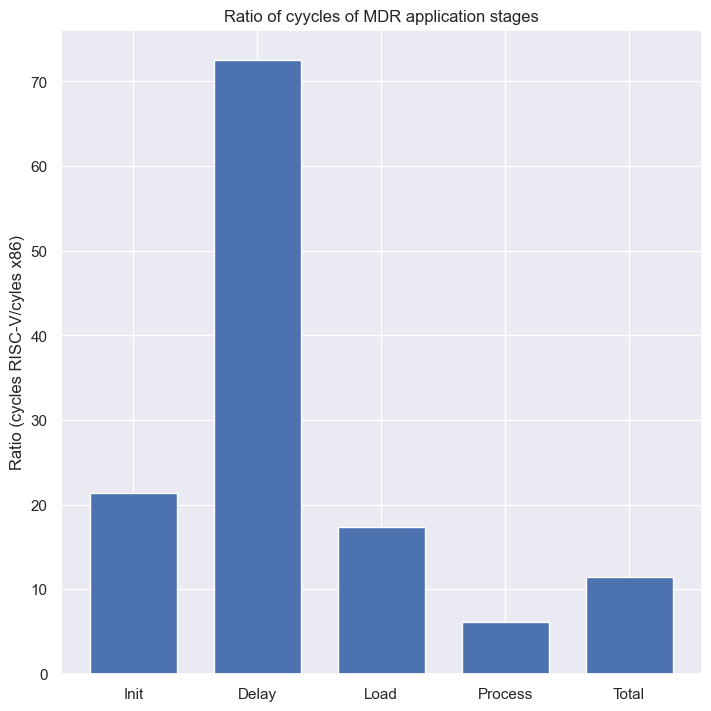

In [31]:
# Create list of ratios
cycles_ratio = (cycles_init_ratio, cycles_delays_ratio, cycles_jobs_load_ratio, cycles_jobs_run_ratio, cycles_total_ratio)
labels = ("Init", "Delay", "Load", "Process", "Total")

# Values of plot
width = 0.7  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_figwidth(7)
fig.set_figheight(7)

#ax.bar(labels, cycles_ratio, width, labels)

print(cycles_ratio)
for measurement, attribute in zip(cycles_ratio, labels):
    offset = width * multiplier
    print(multiplier, measurement, width)
    ax.bar(attribute, measurement, width, label=attribute, color=sns.color_palette()[0])
    multiplier+=1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Ratio (cycles RISC-V/cyles x86)')
ax.set_title('Ratio of cyycles of MDR application stages')
#ax.set_ylim(0, cycles_total_ratio*1.3)

plt.savefig('total.png')

plt.show()


RISC-V (284676000000.0, 1275229200000.0, 985088400000.0, 1775006400000.0, 4320000000000)
x86 (13314600000.0, 17591600000.0, 56864600000.0, 289229200000.0, 377000000000)
21.38073993961516 Init
72.49080242843175 Delay
17.32340331242988 Load
6.13702350938287 Process
11.458885941644562 Total
6.568108435193029 Init
30.440217838557427 Delay
22.466992617693332 Load
35.962173544717416 Process


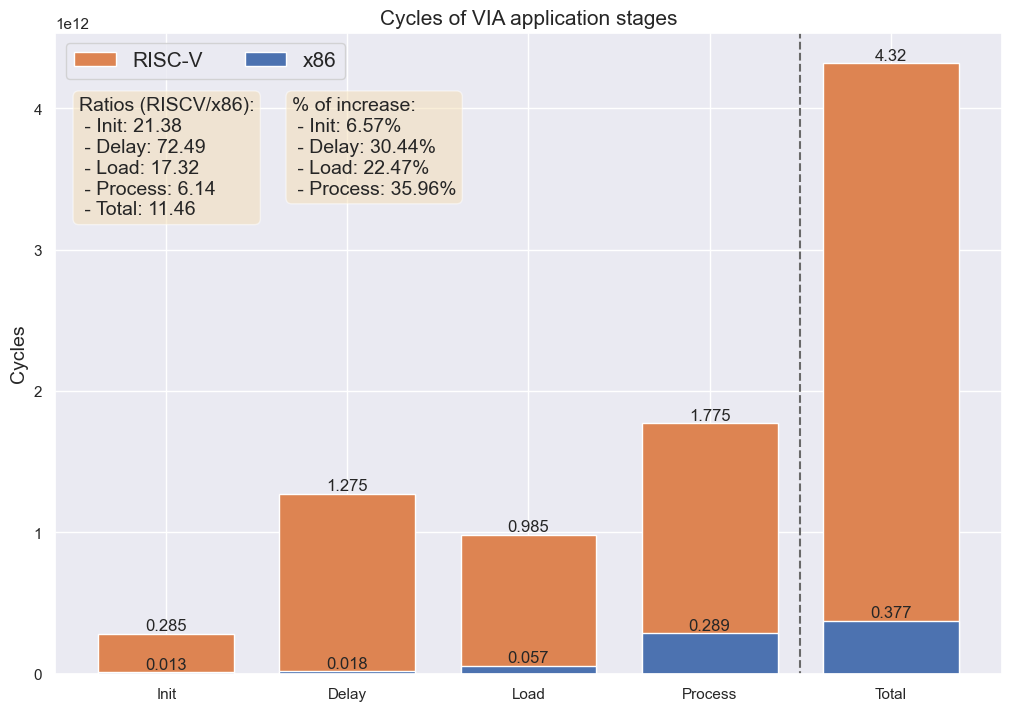

In [85]:
# Create list of elements to plot
labels = ("Init", "Delay", "Load", "Process", "Total")
cycles = {
    'RISC-V': (init_cycles_riscv, total_cycles_delays_riscv, total_cycles_jobs_load_riscv, total_cycles_jobs_run_riscv, cycles_total_riscv),
    'x86': (init_cycles_x86, total_cycles_delays_x86, total_cycles_jobs_load_x86, total_cycles_jobs_run_x86, cycles_total_x86)
}
ratios = [cycles_init_ratio, cycles_delays_ratio, cycles_jobs_load_ratio, cycles_jobs_run_ratio, cycles_total_ratio]
total_inc = sum(cycles['RISC-V'][0:-1]) - sum(cycles['x86'][0:-1])/2
increases = [(cycles['RISC-V'][0] - cycles['x86'][0])/total_inc*100, 
        (cycles['RISC-V'][1] - cycles['x86'][1])/total_inc*100, 
        (cycles['RISC-V'][2] - cycles['x86'][2])/total_inc*100,
        (cycles['RISC-V'][3] - cycles['x86'][3])/total_inc*100]

# Values of plot
width = 0.75  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_figwidth(10)
fig.set_figheight(7)

#ax.bar(labels, cycles_ratio, width, labels)

# Plot Bars
n = 0
for attribute, measurement in cycles.items():
    print(attribute, measurement)
    offset = 0.0 + width * multiplier
    if n == 0:
        c = color=sns.color_palette()[1]
    elif n == 1:
        c =sns.color_palette()[0]
    rects = ax.bar(x, measurement, width, label=attribute, color = c)
    n += 1

# Add labels
rects = ax.patches
n = 0
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, measurement[n] + 5, round(measurement[n]/1000000000000,3), ha="center", va="bottom")
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, round(height/1000000000000,3), ha="center", va="bottom")
    n+=1

# Add Ratios text box
text_ratios = "Ratios (RISCV/x86):"
for r, l in zip(ratios, labels):
    print(r, l)
    text_ratios = "".join({text_ratios + "\n - " + l + ": " + str(round(r,2))})
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.025, 0.9, text_ratios, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

# Add % increase text box
text_increase = "% of increase:"
for i, l in zip(increases, labels):
    print(i, l)
    text_increase = "".join({text_increase + "\n - " + l + ": " + str(round(i,2)) + "%"})
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.25, 0.9, text_increase, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cycles', fontsize=14)
ax.set_title('Cycles of VIA application stages', fontsize=15)
ax.set_ylim(0, cycles_total_riscv*1.05)
ax.set_xticks(x, arch)
ax.legend(loc='upper left', ncols=2, fontsize=15)
ax.axvline(3.5, 0, linestyle='--', c = "dimgray")

plt.savefig('figures/ratios_increase.png')

plt.show()


Increase of cycles due to phase Init: 271.3614
Increase of cycles due to phase Delay: 1257.6376
Increase of cycles due to phase Load: 928.2238
Increase of cycles due to phase Run: 1485.7772
Increase of cycles due to all phases: 3943.0


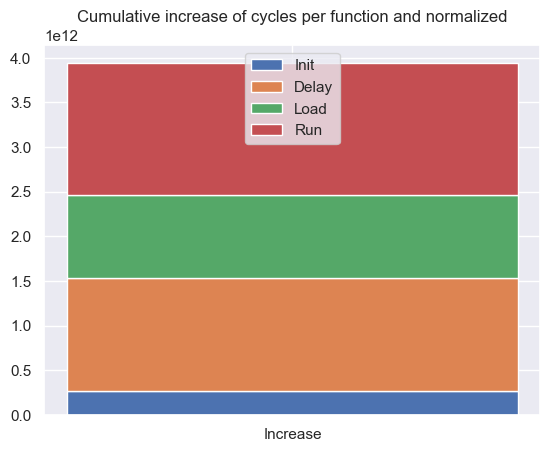

In [33]:
increases = {
    "Init": cycles['RISC-V'][0] - cycles['x86'][0],
    "Delay": cycles['RISC-V'][1] - cycles['x86'][1],
    "Load": cycles['RISC-V'][2] - cycles['x86'][2],
    "Run": cycles['RISC-V'][3] - cycles['x86'][3]
}

width = 0.4

fig, ax = plt.subplots()

bottom = 0
for job_name, cl in increases.items():
    p = ax.bar('Increase', cl, width, label=job_name, bottom=bottom)
    bottom += cl
    print("Increase of cycles due to phase " + job_name + ": " + str(cl/1000000000))

print("Increase of cycles due to all phases: " + str(sum(increases.values())/1000000000))


ax.set_title("Cumulative increase of cycles per function and normalized")
ax.legend(loc="upper center")

plt.show()

In [34]:
print(cycles['RISC-V'][0]/cycles['RISC-V'][4]*100 , cycles['x86'][0]/cycles['x86'][4]*100)
print(cycles['RISC-V'][1]/cycles['RISC-V'][4]*100 , cycles['x86'][1]/cycles['x86'][4]*100)
print(cycles['RISC-V'][2]/cycles['RISC-V'][4]*100 , cycles['x86'][2]/cycles['x86'][4]*100)
print(cycles['RISC-V'][3]/cycles['RISC-V'][4]*100 , cycles['x86'][3]/cycles['x86'][4]*100)


6.589722222222222 3.5317241379310347
29.519194444444448 4.666206896551724
22.802972222222223 15.083448275862068
41.08811111111111 76.71862068965517


# STANDALONE ANALYSIS

## EXTRACT DATA

### EXTRACT X86 STANDALONE INFORMATION

In [34]:
# LOAD X86 DATA
with open(datapath + 'run_x86_st/x86st_app_I_W1_C4_F5') as f_x86_st:
    lines_x86_st = f_x86_st.readlines()

In [35]:
# MAIN
# Extract main information from jobs 
events_x86_st = get_main_job_info(lines_x86_st)

# Get event info dict where key is the job ID and value a dict with times information and job name
event_times_by_ID_x86_st = get_times_by_job_ID(events_x86_st)

# Get event info dict where key is the job name and value a dict with times information
event_times_by_name_x86_st = get_times_by_names(event_times_by_ID_x86_st)

# Get run time dict where key is the job name and value the running time
run_times_by_name_x86_st, run_times_by_ID_x86_st = get_run_times_by_names_and_ID(event_times_by_ID_x86_st)

# Get delay time dict where key is the job name and value a dict with previos and next delay time
delay_times_by_name_x86_st, delay_times_by_ID_x86_st = get_delay_times_by_name_and_ID(event_times_by_ID_x86_st)
data_x86_prev_st, data_x86_next_st = get_prev_next_data(delay_times_by_name_x86_st, FREQ_X86)


### EXTRACT RISC-V STANDALONE INFORMATION

In [36]:
# LOAD X86 DATA
with open(datapath + 'run_riscv_st/riscv_st_app_I_W1_C4_F5') as f_riscv_st:
    lines_riscv_st = f_riscv_st.readlines()

In [37]:
# MAIN
# Extract main information from jobs 
events_riscv_st = get_main_job_info(lines_riscv_st)

# Get event info dict where key is the job ID and value a dict with times information and job name
event_times_by_ID_riscv_st = get_times_by_job_ID(events_riscv_st)

# Get event info dict where key is the job name and value a dict with times information
event_times_by_name_riscv_st = get_times_by_names(event_times_by_ID_riscv_st)

# Get run time dict where key is the job name and value the running time
run_times_by_name_riscv_st, run_times_by_ID_riscv_st = get_run_times_by_names_and_ID(event_times_by_ID_riscv_st)

# Get delay time dict where key is the job name and value a dict with previos and next delay time
delay_times_by_name_riscv_st, delay_times_by_ID_riscv_st = get_delay_times_by_name_and_ID(event_times_by_ID_riscv_st)
data_riscv_prev_st, data_riscv_next_st = get_prev_next_data(delay_times_by_name_riscv_st, FREQ_RISCV)


### EXTRACT X86 2 NODES INFORMATION

In [38]:
# LOAD X86 DATA
with open(datapath + 'run_x86/x86_app_I1_W1_C4_F5') as f_x86:
    lines_x86 = f_x86.readlines()

In [39]:
# MAIN
# Extract main information from jobs 
events_x86 = get_main_job_info(lines_x86)

# Get event info dict where key is the job ID and value a dict with times information and job name
event_times_by_ID_x86 = get_times_by_job_ID(events_x86)

# Get event info dict where key is the job name and value a dict with times information
event_times_by_name_x86 = get_times_by_names(event_times_by_ID_x86)

# Get run time dict where key is the job name and value the running time
run_times_by_name_x86, run_times_by_ID_x86 = get_run_times_by_names_and_ID(event_times_by_ID_x86)

# Get delay time dict where key is the job name and value a dict with previos and next delay time
delay_times_by_name_x86, delay_times_by_ID_x86 = get_delay_times_by_name_and_ID(event_times_by_ID_x86)
data_x86_prev, data_x86_next = get_prev_next_data(delay_times_by_name_x86, FREQ_X86)



### EXTRACT RISC-V 2 NODES INFORMATION

In [40]:
# LOAD X86 DATA
with open(datapath + 'run_riscv/riscv_app_I1_W1_C4_F5') as f_riscv:
    lines_riscv = f_riscv.readlines()

In [41]:
# MAIN
# Extract main information from jobs 
events_riscv = get_main_job_info(lines_riscv)

# Get event info dict where key is the job ID and value a dict with times information and job name
event_times_by_ID_riscv = get_times_by_job_ID(events_riscv)

# Get event info dict where key is the job name and value a dict with times information
event_times_by_name_riscv = get_times_by_names(event_times_by_ID_riscv)

# Get run time dict where key is the job name and value the running time
run_times_by_name_riscv, run_times_by_ID_riscv = get_run_times_by_names_and_ID(event_times_by_ID_riscv)

# Get delay time dict where key is the job name and value a dict with previos and next delay time
delay_times_by_name_riscv, delay_times_by_ID_riscv = get_delay_times_by_name_and_ID(event_times_by_ID_riscv)
data_riscv_prev, data_riscv_next = get_prev_next_data(delay_times_by_name_riscv, FREQ_RISCV)


## PLOTS

### X86 TIMES COMPARISON

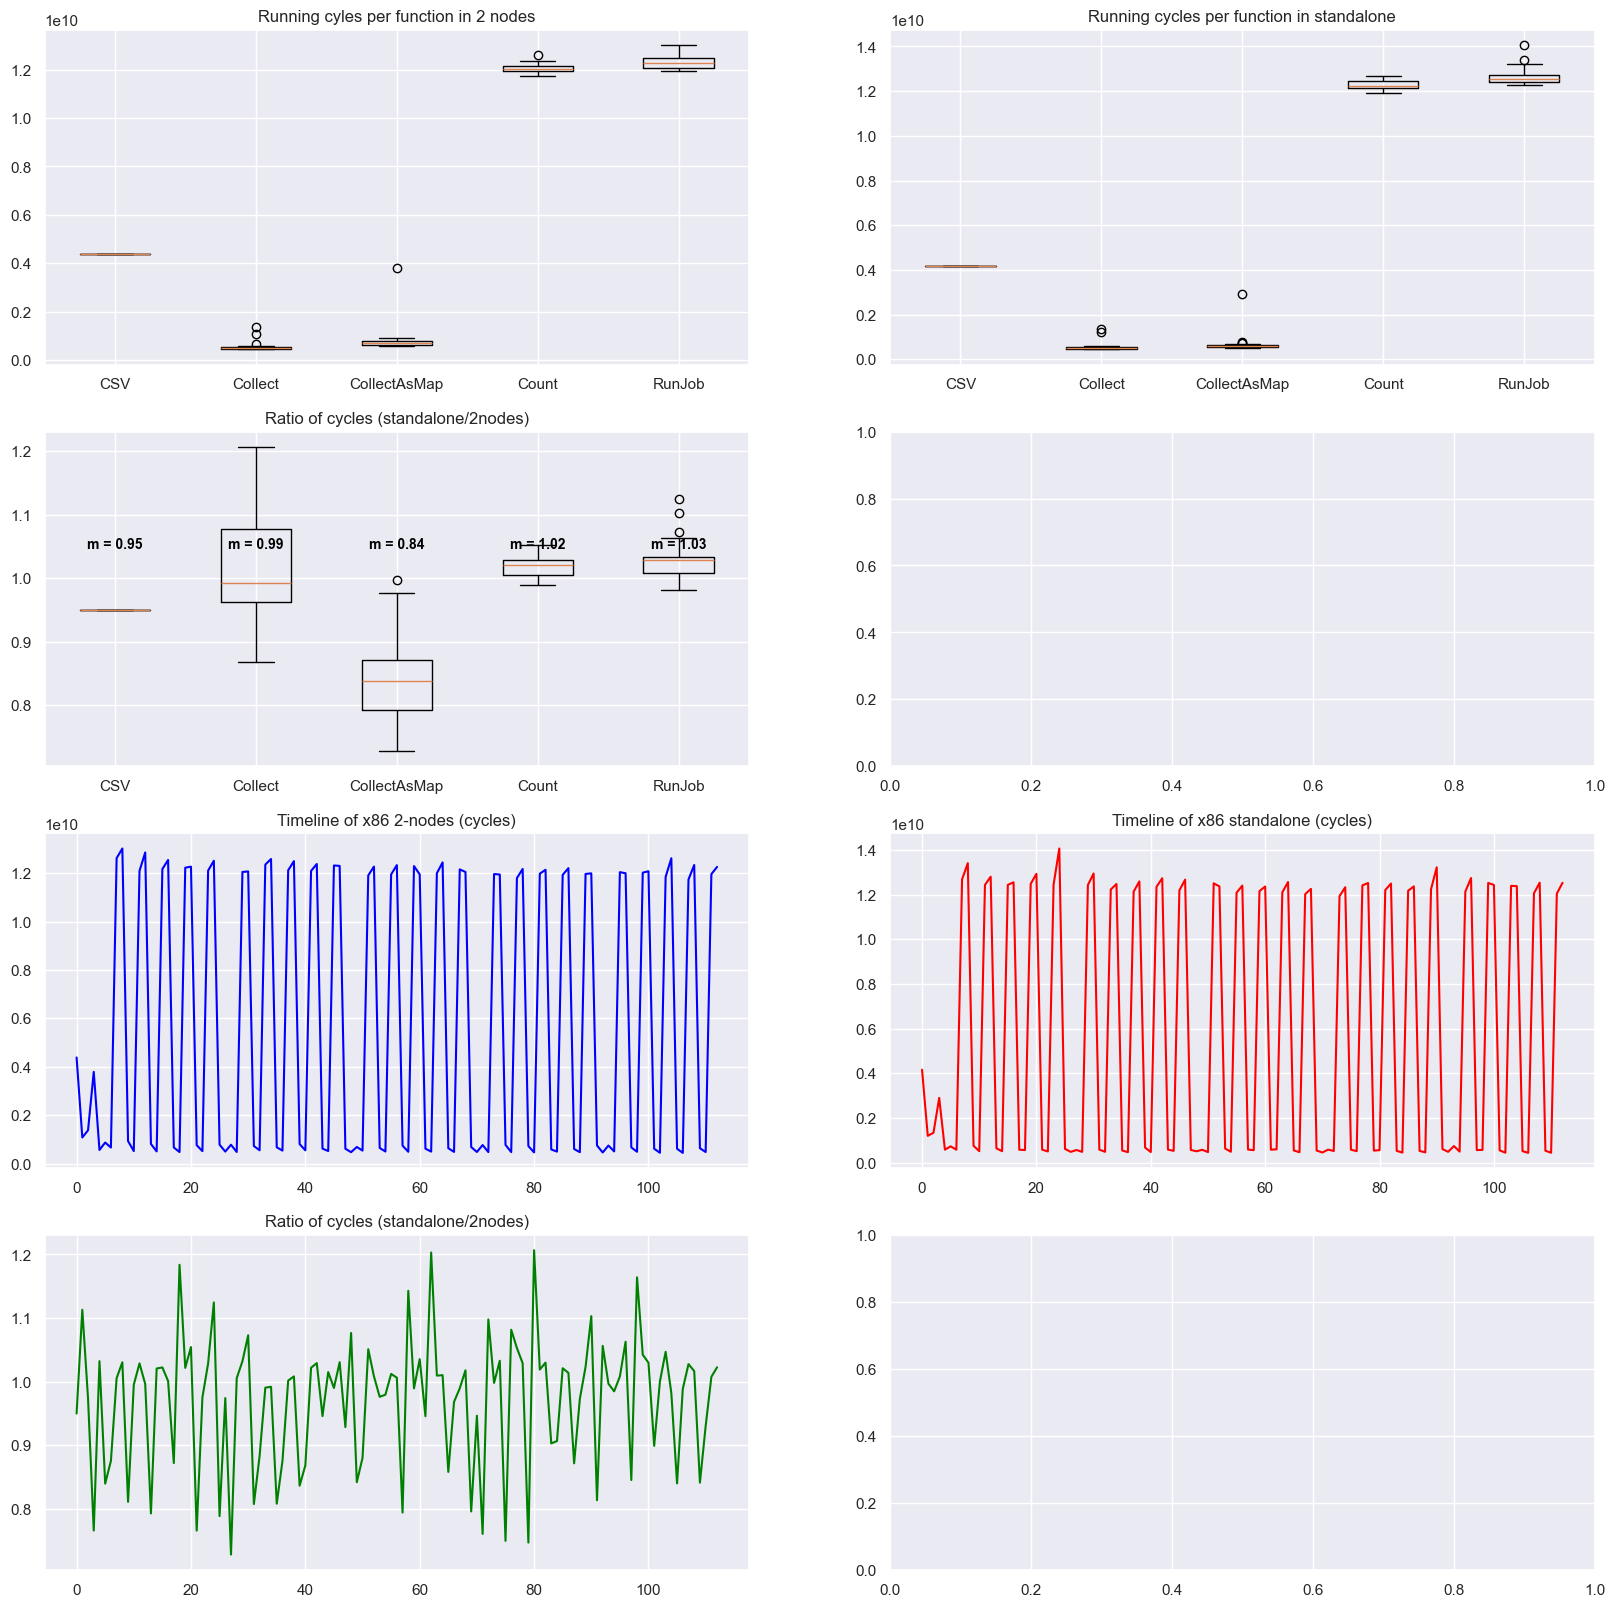

In [42]:
# BOX PLOT
keys_x86 = list(run_times_by_name_x86.keys())
data_x86 = [run_times_by_name_x86[keys_x86[x]] for x in range(len(keys_x86))]
cycles_x86 = runtime_to_cycles(data_x86, FREQ_X86)

keys_x86_st = list(run_times_by_name_x86_st.keys())
data_x86_st = [run_times_by_name_x86_st[keys_x86_st[x]] for x in range(len(keys_x86_st))]
cycles_x86_st = runtime_to_cycles(data_x86_st, FREQ_X86)

ratio_runtimes_x86 = get_ratio_runtimes(cycles_x86, cycles_x86_st)

# Timeline
timeline_x86 = np.array([x*FREQ_X86/1000 for x in list(run_times_by_ID_x86.values())])
timeline_x86_st = np.array([x*FREQ_X86/1000 for x in list(run_times_by_ID_x86_st .values())])

ratio_timeline = timeline_x86_st/timeline_x86

labels = ['CSV', 'Collect', 'CollectAsMap', 'Count', 'RunJob']
num_boxes = len(labels)

fig, ax = plt.subplots(4,2)
fig.set_figwidth(20)
fig.set_figheight(20)

# Box plots
ax[0][0].set_title('Running cyles per function in 2 nodes')
bp = ax[0][0].boxplot(cycles_x86, labels=labels)
#add_median_to_ax(bp, ax[0][0], num_boxes)

ax[0][1].set_title('Running cycles per function in standalone')
bp = ax[0][1].boxplot(cycles_x86_st, labels=labels)
#add_median_to_ax(bp, ax[0][1], num_boxes)

# Ratio
ax[1][0].set_title('Ratio of cycles (standalone/2nodes)')
bp = ax[1][0].boxplot(ratio_runtimes_x86, labels=labels)
add_median_to_ax(bp, ax[1][0], num_boxes, .65)

# Time line
ax[2][0].set_title('Timeline of x86 2-nodes (cycles)')
ax[2][0].plot(timeline_x86, color = 'blue')
ax[2][1].set_title('Timeline of x86 standalone (cycles)')
ax[2][1].plot(timeline_x86_st, color = 'red')

# Ratio
ax[3][0].set_title('Ratio of cycles (standalone/2nodes)')
ax[3][0].plot(ratio_timeline, color = 'green')


plt.show()


### RISCV TIMES COMPARISON

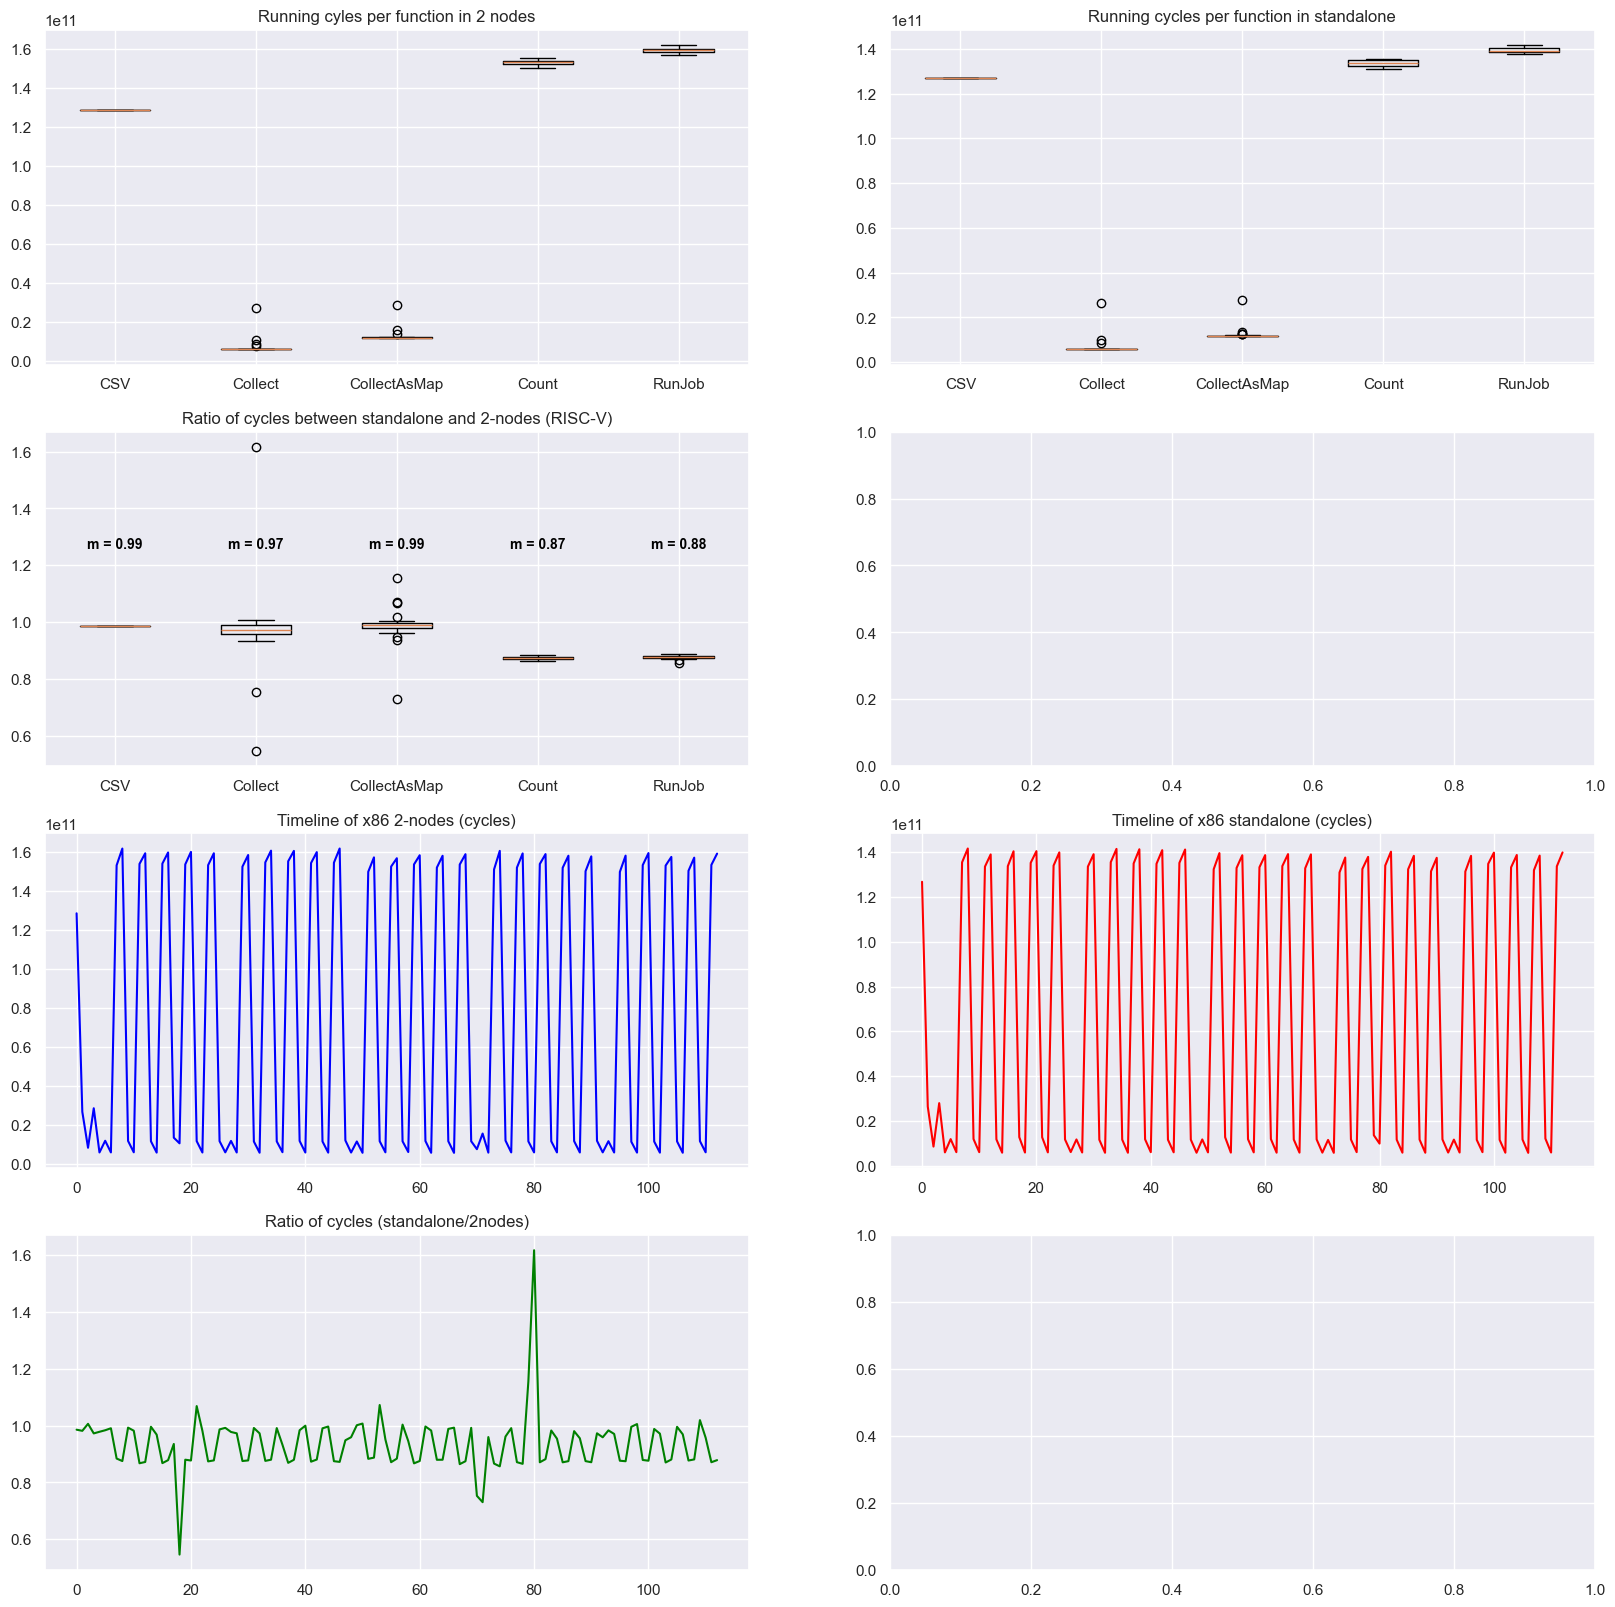

In [43]:
# BOX PLOT
keys_riscv = list(run_times_by_name_riscv.keys())
data_riscv = [run_times_by_name_riscv[keys_riscv[x]] for x in range(len(keys_riscv))]
cycles_riscv = runtime_to_cycles(data_riscv, FREQ_RISCV)

keys_riscv_st = list(run_times_by_name_riscv_st.keys())
data_riscv_st = [run_times_by_name_riscv_st[keys_riscv_st[x]] for x in range(len(keys_riscv_st))]
cycles_riscv_st = runtime_to_cycles(data_riscv_st, FREQ_RISCV)

ratio_runtimes_riscv = get_ratio_runtimes(cycles_riscv, cycles_riscv_st)

# Timeline
timeline_riscv = np.array([x*FREQ_RISCV/1000 for x in list(run_times_by_ID_riscv.values())])
timeline_riscv_st = np.array([x*FREQ_RISCV/1000 for x in list(run_times_by_ID_riscv_st .values())])

ratio_timeline = timeline_riscv_st/timeline_riscv

labels = ['CSV', 'Collect', 'CollectAsMap', 'Count', 'RunJob']
num_boxes = len(labels)

fig, ax = plt.subplots(4,2)
fig.set_figwidth(20)
fig.set_figheight(20)

# Box plots
ax[0][0].set_title('Running cyles per function in 2 nodes')
bp = ax[0][0].boxplot(cycles_riscv, labels=labels)
#add_median_to_ax(bp, ax[0][0], num_boxes)

ax[0][1].set_title('Running cycles per function in standalone')
bp = ax[0][1].boxplot(cycles_riscv_st, labels=labels)
#add_median_to_ax(bp, ax[0][1], num_boxes)

# Ratio
ax[1][0].set_title('Ratio of cycles between standalone and 2-nodes (RISC-V)')
bp = ax[1][0].boxplot(ratio_runtimes_riscv, labels=labels)
add_median_to_ax(bp, ax[1][0], num_boxes, .65)

# Time line
ax[2][0].set_title('Timeline of x86 2-nodes (cycles)')
ax[2][0].plot(timeline_riscv, color = 'blue')
ax[2][1].set_title('Timeline of x86 standalone (cycles)')
ax[2][1].plot(timeline_riscv_st, color = 'red')

# Ratio
ax[3][0].set_title('Ratio of cycles (standalone/2nodes)')
ax[3][0].plot(ratio_timeline, color = 'green')


plt.show()


### RISCV VS X86 COMPARISON OF JOBS

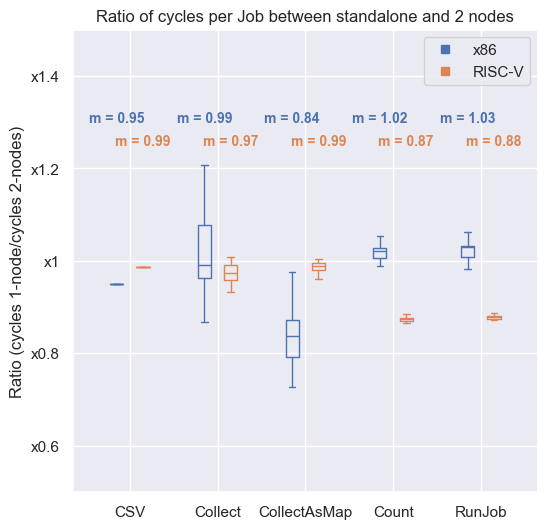

In [55]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)

# Ratio
n=-0.15
m=+0.15
c = sns.color_palette()[0]
c2 = sns.color_palette()[1]
ax.set_title('Ratio of cycles per Job between standalone and 2 nodes')
bp = ax.boxplot(ratio_runtimes_x86, labels=labels, positions=(1+n,2+n,3+n,4+n,5+n), widths=0.15, showfliers=False)
add_median_to_ax(bp, ax, num_boxes, .80, n, c)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color=c)

bp = ax.boxplot(ratio_runtimes_riscv, labels=("","","","",""), positions=(1+m,2+m,3+m,4+m,5+m), widths=0.15, showfliers=False)
add_median_to_ax(bp, ax, num_boxes, .75, m, c2)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color=c2)

ax.set_ylim((0.5,1.5))
plt.xticks(np.array(range(len(labels)))+1, labels, rotation='horizontal')

x86 = mlines.Line2D([], [], color=c, marker='s', ls='', label='x86')
riscv = mlines.Line2D([], [], color=c2, marker='s', ls='', label='RISC-V')

# etc etc
plt.legend(handles=[x86, riscv])
ax.set_yticks((0.6,0.8,1.0,1.2,1.4))
ax.set_yticklabels(("x0.6","x0.8","x1","x1.2","x1.4"))
ax.set_ylabel('Ratio (cycles 1-node/cycles 2-nodes)')

plt.savefig('figures/standalone.png', bbox_inches='tight')
plt.show()

### RISCV VS X86 COMPARISON OF STAGES

In [56]:
# GET RATIOS
# x86
ratio_delays_x86 = list(itertools.chain.from_iterable(get_ratio_delays(data_x86_next, data_x86_next_st)))
ratio_init_x86 = ratio_runtimes_x86[0]
ratio_load_x86 = list(itertools.chain.from_iterable(ratio_runtimes_x86[1:3]))
ratio_run_x86 = list(itertools.chain.from_iterable(ratio_runtimes_x86[3:]))
ratio_total_x86 = list(itertools.chain.from_iterable(ratio_runtimes_x86)) + ratio_delays_x86

ratio_stages_x86 = [ratio_init_x86, ratio_delays_x86, ratio_load_x86, ratio_run_x86]

# RISC-V
ratio_delays_riscv = list(itertools.chain.from_iterable(get_ratio_delays(data_riscv_next, data_riscv_next_st)))
ratio_init_riscv = ratio_runtimes_riscv[0]
ratio_load_riscv = list(itertools.chain.from_iterable(ratio_runtimes_riscv[1:3]))
ratio_run_riscv = list(itertools.chain.from_iterable(ratio_runtimes_riscv[3:]))
ratio_total_riscv = list(itertools.chain.from_iterable(ratio_runtimes_riscv)) + ratio_delays_riscv

ratio_stages_riscv = [ratio_init_riscv, ratio_delays_riscv, ratio_load_riscv, ratio_run_riscv]


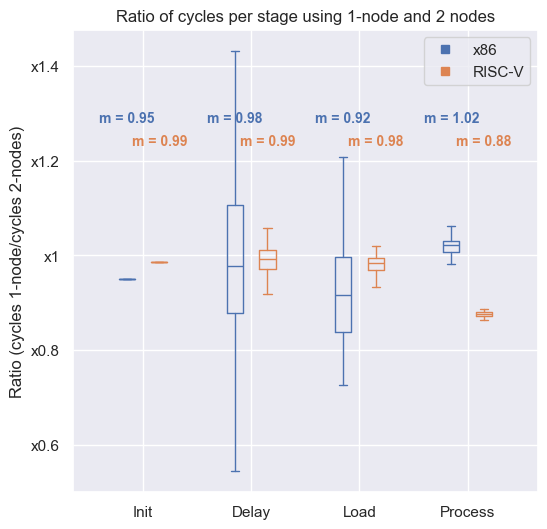

In [62]:
fig, ax = plt.subplots()
fig.set_figwidth(6)
fig.set_figheight(6)

# Ratio
n=-0.15
m=+0.15
c = sns.color_palette()[0]
c2 = sns.color_palette()[1]
labels = ("Init", "Delay", "Load", "Process")

ax.set_title('Ratio of cycles per stage using 1-node and 2 nodes')
bp = ax.boxplot(ratio_stages_x86, labels=labels, positions=(1+n,2+n,3+n,4+n), widths=0.15, showfliers=False)
add_median_to_ax(bp, ax, len(labels), .80, n, c)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color=c)

bp = ax.boxplot(ratio_stages_riscv, labels=labels, positions=(1+m,2+m,3+m,4+m), widths=0.15, showfliers=False)
add_median_to_ax(bp, ax, len(labels), .75, m, c2)
for item in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[item], color=c2)

#ax.set_ylim((0.5,1.5))

x86 = mlines.Line2D([], [], color=c, marker='s', ls='', label='x86')
riscv = mlines.Line2D([], [], color=c2, marker='s', ls='', label='RISC-V')
ax.set_xticks([1,2,3,4], labels)
#ax.set_xlabel("Block size (bytes)")
ax.set_yticks((0.6,0.8,1.0,1.2,1.4))
ax.set_yticklabels(("x0.6","x0.8","x1","x1.2","x1.4"))
ax.set_ylabel('Ratio (cycles 1-node/cycles 2-nodes)')

# etc etc
plt.legend(handles=[x86, riscv])
plt.savefig('figures/stages_standalone.png', bbox_inches='tight')
plt.show()

# MEMORY ANALYSIS


### Load data

In [68]:
# Load data
import math
x86testpath = "data/memory/x86test.txt"
riscvtestpath = "data/memory/riscvtest.txt"

In [69]:
with open(x86testpath) as t_x86:
    lines_t86 = t_x86.readlines()

with open(riscvtestpath) as t_riscv:
    lines_triscv = t_riscv.readlines()

In [70]:
# Read info
bytes = list()
bytes_l = list()
ns_x86 = list()
speed_x86 = list()
ns_x86_c = list()
speed_x86_c = list()

ns_riscv = list()
speed_riscv = list()
ns_riscv_c = list()
speed_riscv_c = list()

n = 0
for f in lines_t86:
    if n == 1:
        aux = f.strip().split()
        if float(aux[0]) == 0:
            bytes_l.append(0)
        else:
            bytes_l.append(math.log(float(aux[0]),10))
        bytes.append(aux[0])
        ns_x86_c.append(float(aux[2])*FREQ_X86)
        speed_x86_c.append(float(aux[3])/FREQ_X86)
        ns_x86.append(float(aux[2]))
        speed_x86.append(float(aux[3]))

    else:
        n = 1

n = 0
for f in lines_triscv:
    if n == 1:
        aux = f.strip().split()
        ns_riscv_c.append(float(aux[2])*FREQ_RISCV)
        speed_riscv_c.append(float(aux[3])/FREQ_RISCV)
        ns_riscv.append(float(aux[2]))
        speed_riscv.append(float(aux[3]))
    else:
        n = 1

In [71]:
labels_bt = ['0','1','2','4','8','16','32','64','128','256','512','1KB','2KB','4KB','8KB','16KB','32KB','64KB','128KB','256KB','512KB','1MB','2MB','4MB','8MB','16MB','32MB','64MB']
print(len(labels_bt), len(bytes))
print(bytes)

28 28
['0', '1', '2', '4', '8', '16', '32', '64', '128', '256', '512', '1024', '2048', '4096', '8192', '16384', '32768', '65536', '131072', '262144', '524288', '1048576', '2097152', '4194304', '8388608', '16777216', '33554432', '67108864']


### Plot graphs

/var/folders/ts/s6bz2xy90jdcbfv61sgwgkp00000gn/T/ipykernel_96366/1332803838.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(labels_bt[7:-3], rotation=45)
/var/folders/ts/s6bz2xy90jdcbfv61sgwgkp00000gn/T/ipykernel_96366/1332803838.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(labels_bt[7:-3], rotation=45)


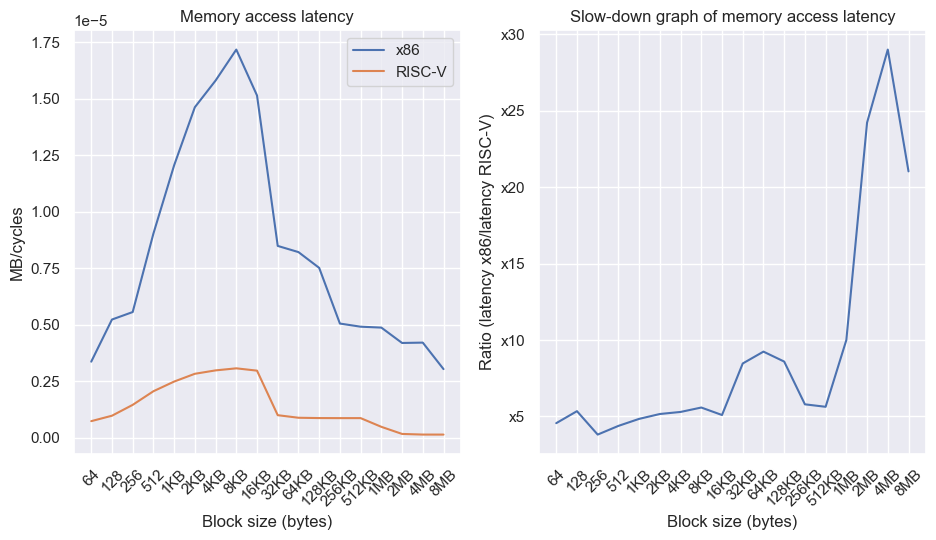

In [74]:
sns.color_palette()
sns.set_theme()

fig, ax = plt.subplots(1,2)
fig.set_figwidth(11)
fig.set_figheight(5.5)

ax[0].set_title('Memory access latency')
bp = ax[0].plot(bytes[7:-3], speed_x86_c[7:-3])
bp = ax[0].plot(bytes[7:-3], speed_riscv_c[7:-3])
ax[0].set_xticklabels(labels_bt[7:-3], rotation=45)
ax[0].set_xlabel("Block size (bytes)")
ax[0].set_ylabel('MB/cycles')
ax[0].legend(('x86','RISC-V'), loc="upper right")

ax[1].set_title('Slow-down graph of memory access latency')
bp = ax[1].plot(bytes[7:-3], np.array(np.array(speed_x86_c[7:-3])/speed_riscv_c[7:-3]))
ax[1].set_xticklabels(labels_bt[7:-3], rotation=45)
ax[1].set_xlabel("Block size (bytes)")
ax[1].set_ylabel("Ratio (latency x86/latency RISC-V)")
ax[1].set_yticks((5,10,15,20,25,30))
ax[1].set_yticklabels(("x5","x10","x15","x20","x25","x30"))


plt.savefig('figures/memorylatency.png', bbox_inches='tight')


In [ ]:
# Box plots
ax[0][0].set_title('')
bp = ax[0][0].plot(bytes, ns_x86)
bp = ax[0][0].plot(bytes, ns_riscv)
#add_median_to_ax(bp, ax[0][0], num_boxes)

# Ratio
ax[1][0].set_title('Speed (MB/s)')
bp = ax[1][0].plot(bytes, speed_x86)
bp = ax[1][0].plot(bytes, speed_riscv)


# PYTHON VS SPARK ANALYSIS

In [73]:
with open('data/python_cycles.pkl', 'rb') as fp:
    cycles_python = pickle.load(fp)

with open('data/ratios_cycles.pkl', 'rb') as fp:
    ratios_cycles = pickle.load(fp)

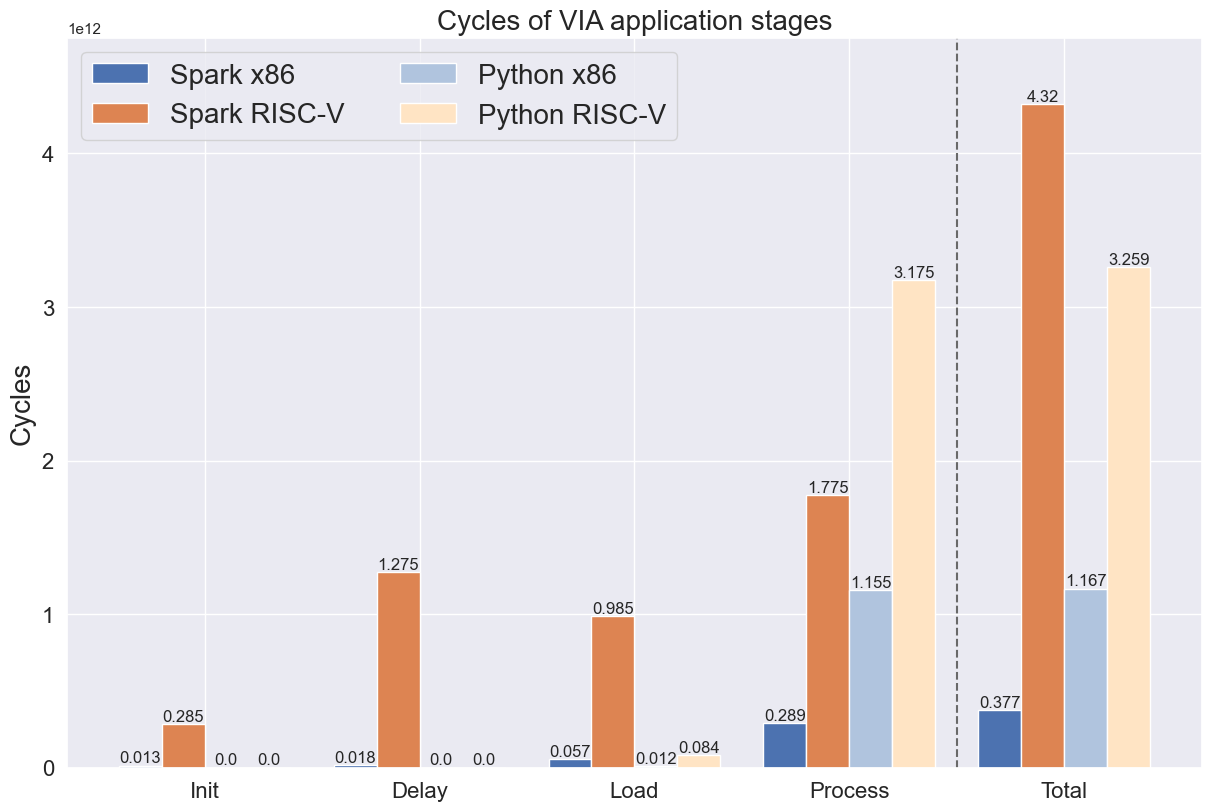

In [80]:
sns.color_palette()
sns.set_theme()

new_cycles_python = dict()
for k, v in cycles_python.items():
    new_cycles_python[k] = (v[0], 0, v[1], v[2] + v[3], v[4])

# Create list of values
labels = ("Init", "Delay", "Load", "Process", "Total")
cycles = {
    'Spark x86': (init_cycles_x86, total_cycles_delays_x86, total_cycles_jobs_load_x86, total_cycles_jobs_run_x86, cycles_total_x86),
    'Spark RISC-V': (init_cycles_riscv, total_cycles_delays_riscv, total_cycles_jobs_load_riscv, total_cycles_jobs_run_riscv, cycles_total_riscv),
    'Python x86': new_cycles_python['x86'],
    'Python RISC-V': new_cycles_python['RISC-V']

}
ratios = [cycles_init_ratio, cycles_delays_ratio, cycles_jobs_load_ratio, cycles_jobs_run_ratio, cycles_total_ratio]
ratios_label = ['r = ' + str(round(r, 2)) for r in ratios]

# Values of plot
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.set_figwidth(12)
fig.set_figheight(8)
fsize = 20

# Plot Bars
for attribute, measurement in cycles.items():
    offset = -0.1 + width * multiplier
    if multiplier == 3:
        rects = ax.bar(x + offset, measurement, width, label=attribute, color="bisque")
    elif multiplier == 2:
        rects = ax.bar(x + offset, measurement, width, label=attribute, color="lightsteelblue")
    else:
        rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
        

    
# Add labels
rects = ax.patches    
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, round(height/1000000000000,3), ha="center", va="bottom")



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Cycles')
ax.set_title('Cycles of VIA application stages')
ax.title.set_size(fsize)
ax.yaxis.get_label().set_fontsize(fsize)
ax.set_xticks(x + width, labels)
ax.tick_params(axis='both', which='major', labelsize=fsize-4)
ax.legend(loc='upper left', ncols=2, fontsize="20")
ax.set_ylim(0, cycles_total_riscv*1.1)
ax.axvline(3.7, 0, linestyle='--', c = "dimgray")

plt.savefig('figures/spark_vs_python_bars.png')

plt.show()


RISC-V (284676000000.0, 1275229200000.0, 985088400000.0, 1775006400000.0, 4320000000000)
x86 (13314600000.0, 17591600000.0, 56864600000.0, 289229200000.0, 377000000000)


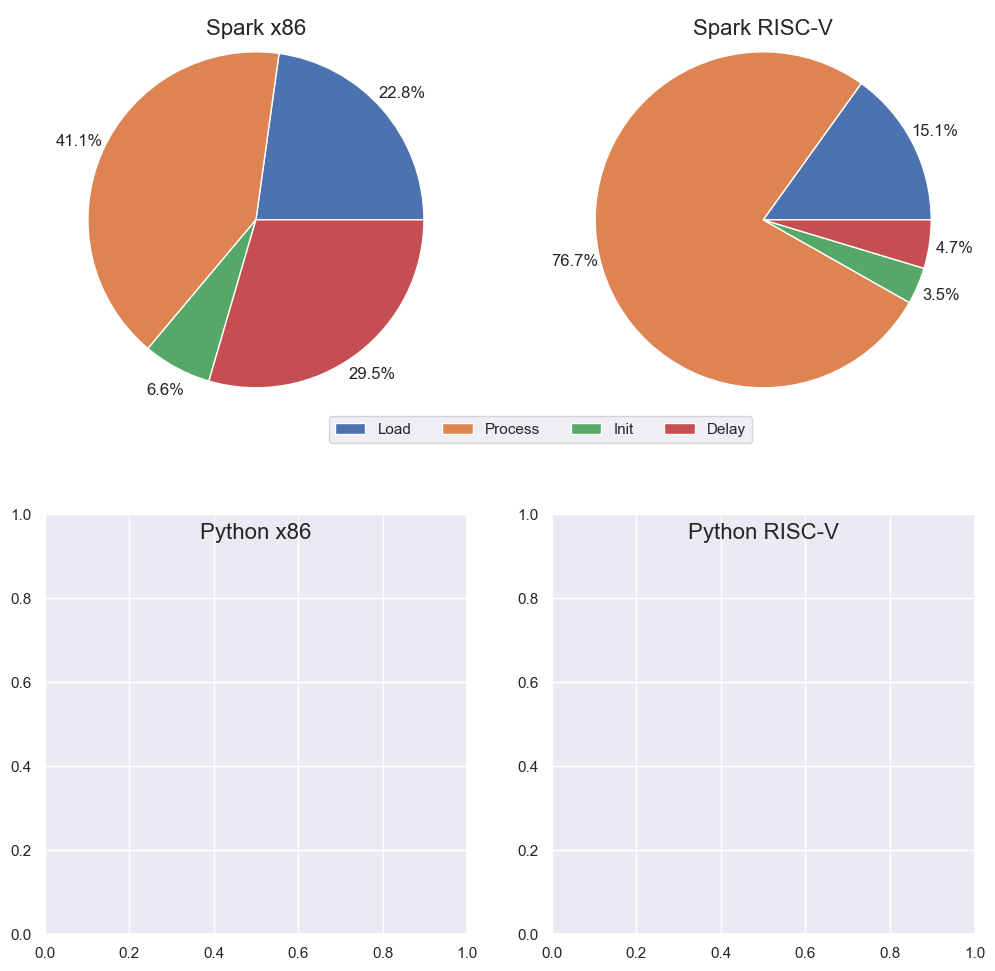

In [71]:
fig, ax = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(12)


n = 0
for k, v in cycles.items():
    print(k,v)
    if n == 0:
        vals = [v[2], v[3], v[0], v[1]]
        labs = [labels[2], labels[3], labels[0], labels[1]]
        ax[0][0].pie(vals, autopct='%1.1f%%', pctdistance=1.15)
        ax[0][0].legend(labels=labs, loc='upper right', bbox_to_anchor=(1.7, 0.05), ncol = 4)
    if n == 1:
        vals = [v[2], v[3], v[0], v[1]]
        labs = [labels[2], labels[3], labels[0], labels[1]]
        ax[0][1].pie(vals, autopct='%1.1f%%', pctdistance=1.15)
    if n == 2:
        ax[1][0].pie(v[2:4], autopct='%1.1f%%', pctdistance=1.15)
    if n == 3:
        ax[1][1].pie(v[2:4], autopct='%1.1f%%', pctdistance=1.15)

    ax[0][0].set_title("Spark x86", y=0.92)
    ax[0][1].set_title("Spark RISC-V",y=0.92)
    ax[1][0].set_title("Python x86",y=0.92)
    ax[1][1].set_title("Python RISC-V",y=0.92)

    ax[0][0].title.set_size(16)
    ax[0][1].title.set_size(16)
    ax[1][0].title.set_size(16)
    ax[1][1].title.set_size(16)


    n+=1

plt.savefig('spark_vs_python_pie.png', bbox_inches='tight')

plt.show()

RISC-V (284676000000.0, 1275229200000.0, 985088400000.0, 1775006400000.0, 4320000000000)
x86 (13314600000.0, 17591600000.0, 56864600000.0, 289229200000.0, 377000000000)


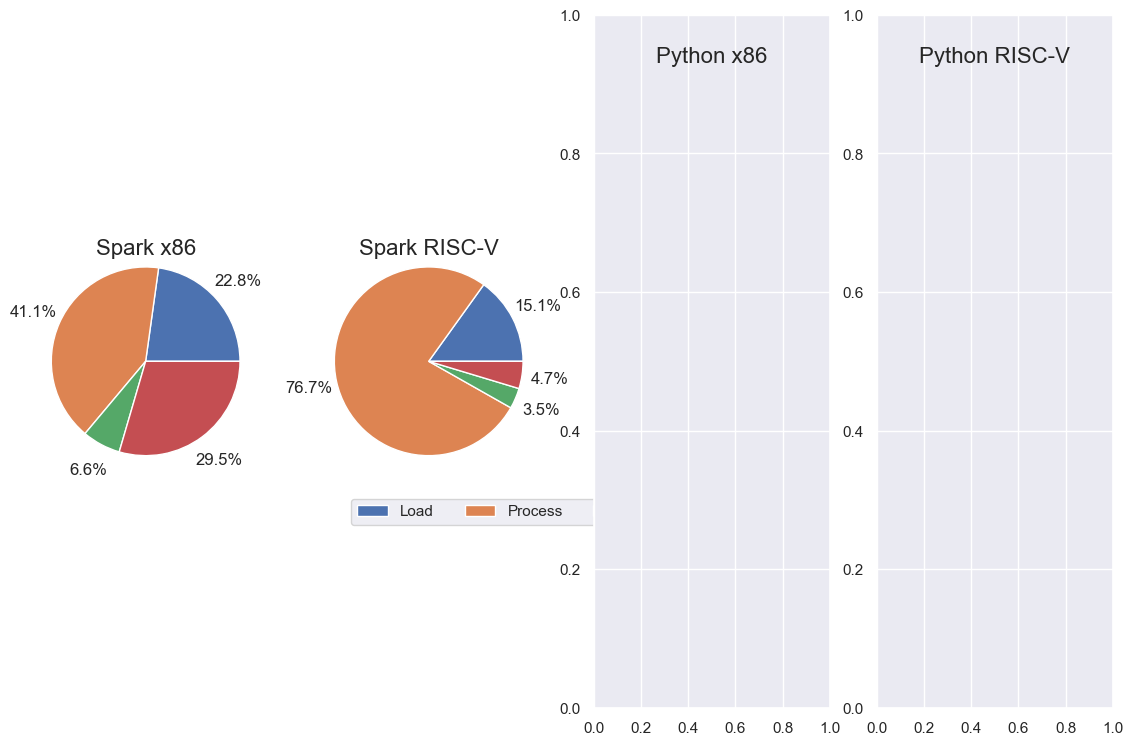

In [72]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(14)
fig.set_figheight(9)


n = 0
for k, v in cycles.items():
    print(k,v)
    if n == 0:
        vals = [v[2], v[3], v[0], v[1]]
        labs = [labels[2], labels[3], labels[0], labels[1]]
        ax[0].pie(vals, autopct='%1.1f%%', pctdistance=1.3)
    if n == 1:
        vals = [v[2], v[3], v[0], v[1]]
        labs = [labels[2], labels[3], labels[0], labels[1]]
        ax[1].pie(vals, autopct='%1.1f%%', pctdistance=1.3)
        ax[1].legend(labels=labs, loc='upper right', bbox_to_anchor=(2, -0.05), ncol = 4)

    if n == 2:
        ax[2].pie(v[2:4], autopct='%1.1f%%', pctdistance=1.3)
    if n == 3:
        ax[3].pie(v[2:4], autopct='%1.1f%%', pctdistance=1.3)

    ax[0].set_title("Spark x86", y=0.92)
    ax[1].set_title("Spark RISC-V",y=0.92)
    ax[2].set_title("Python x86",y=0.92)
    ax[3].set_title("Python RISC-V",y=0.92)

    ax[0].title.set_size(16)
    ax[1].title.set_size(16)
    ax[2].title.set_size(16)
    ax[3].title.set_size(16)


    n+=1

plt.savefig('spark_vs_python_pie_h.png', bbox_inches='tight')

plt.show()

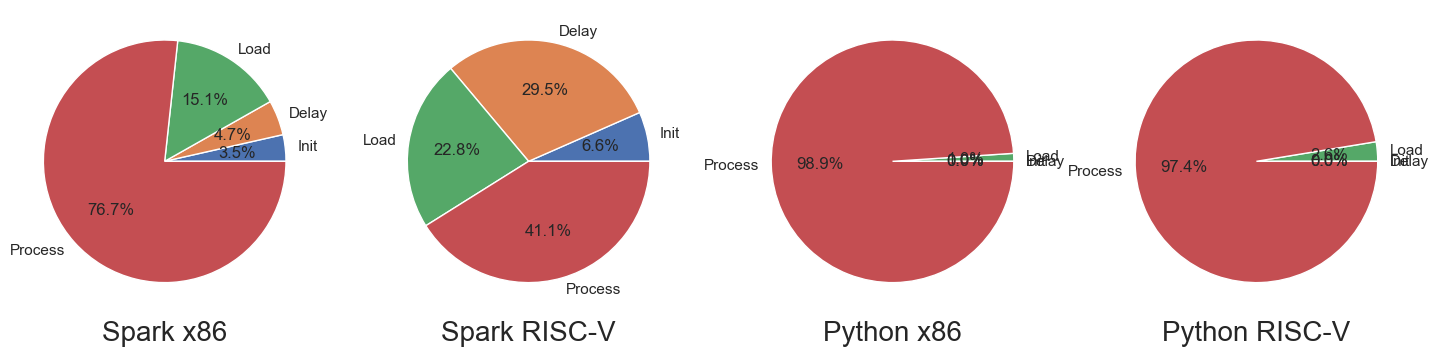

In [405]:
fig, ax = plt.subplots(1,4)
fig.set_figwidth(18)
fig.set_figheight(6)


n = 0
for k, v in cycles.items():
    if n == 0:
        ax[0].pie(v[0:-1], labels=labels[0:-1], autopct='%1.1f%%')
    if n == 1:
        ax[1].pie(v[0:-1], labels=labels[0:-1], autopct='%1.1f%%')
    if n == 2:
        ax[2].pie(v[0:-1], labels=labels[0:-1], autopct='%1.1f%%')
    if n == 3:
        ax[3].pie(v[0:-1], labels=labels[0:-1], autopct='%1.1f%%')

    ax[0].set_title("Spark x86", y=-0.12)
    ax[0].title.set_size(20)
    ax[1].set_title("Spark RISC-V", y=-0.12)
    ax[1].title.set_size(20)
    ax[2].set_title("Python x86", y=-0.12)
    ax[2].title.set_size(20)
    ax[3].set_title("Python RISC-V", y=-0.12)
    ax[3].title.set_size(20)
    
    n+=1
    
plt.savefig('spark_vs_python_pie.png', bbox_inches='tight')

plt.show()

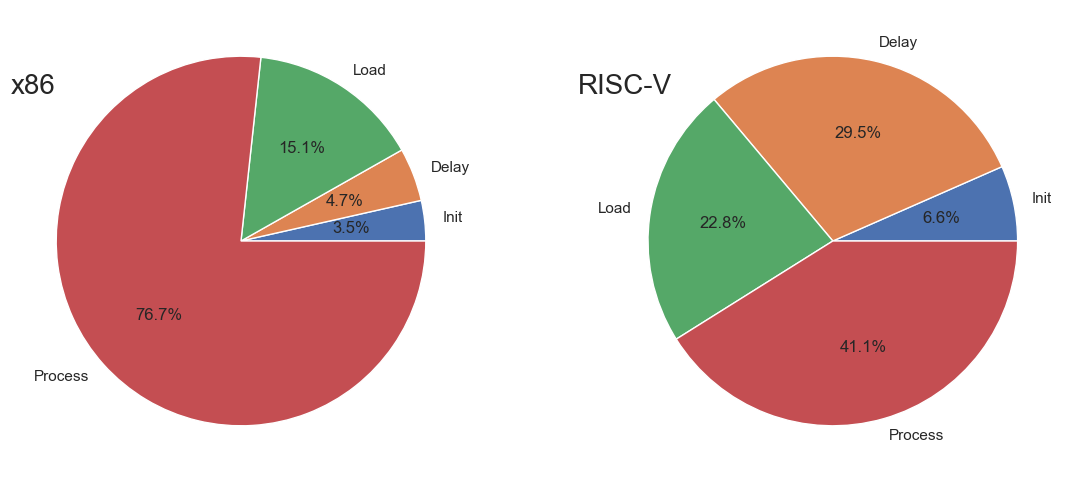

In [437]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(14)
fig.set_figheight(6)


n = 0
for k, v in cycles.items():
    if n == 0:
        ax[0].pie(v[0:-1], labels=labels[0:-1], autopct='%1.1f%%')
    if n == 1:
        ax[1].pie(v[0:-1], labels=labels[0:-1], autopct='%1.1f%%')

    ax[0].set_title("x86", y=0.80, x = 0.05, rotation = 0)
    ax[0].title.set_size(20)
    ax[1].set_title("RISC-V", y=0.80, x = 0.05, rotation = 0)
    ax[1].title.set_size(20)
    
    n+=1
    
plt.savefig('stages_pie.png', bbox_inches='tight')

plt.show()